<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/File_02_Calories_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTING CALOORIES BURNED

## RMSLE Metric and Competition Context

This notebook is developed for a data science competition focused on predicting **Calories burned** during exercise. The evaluation metric for this competition is the **Root Mean Squared Logarithmic Error (RMSLE)**, which measures the square root of the mean squared difference between the logarithms of predicted and actual values. RMSLE is ideal for datasets with a wide range of target values, as it emphasizes **relative errors**, ensuring balanced performance across small and large calorie values.

The RMSLE formula is:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*AUzyQ1rc6mpQVYfn)

### Why RMSLE?
- **Handles Wide Ranges**: RMSLE penalizes relative errors proportionally, making it robust for calorie values ranging from small (e.g., 10 calories) to large (e.g., 1000 calories).
- **Balanced Evaluation**: Ensures models perform well across the entire spectrum of calorie burn.
- **Competition Goal**: A lower RMSLE score indicates a precise and generalizable model, critical for ranking high on the leaderboard.

---

## Potential Effects of Features on Calorie Burn

The dataset includes the following features to predict calorie burn: **Sex**, **Age**, **Height**, **Weight**, **Duration**, **Heart_Rate**, and **Body_Temp**. Below, we explore how each feature might influence calorie burn:

### 1. Sex
- **Impact**: Differences in metabolic rates and muscle mass between males and females affect calorie burn. Males often have higher muscle mass, leading to greater calorie expenditure for the same exercise.
- **Example**: A male running at the same pace and duration as a female may burn more calories due to higher energy demands.

### 2. Age
- **Impact**: Basal metabolic rate (BMR) decreases with age, reducing calorie burn in older individuals due to lower metabolic rates and muscle mass (sarcopenia).
- **Example**: A 20-year-old may burn more calories than a 50-year-old during identical workouts.

### 3. Height
- **Impact**: Taller individuals have more body mass or muscle, requiring more energy for movement, thus burning more calories. Height’s effect is often linked to weight and exercise intensity.
- **Example**: A taller person may expend more energy covering the same distance.

### 4. Weight
- **Impact**: Heavier individuals burn more calories due to the energy required to move greater body mass. Body composition (fat vs. muscle) also influences calorie burn.
- **Example**: A 90 kg individual burns more calories walking the same distance as a 60 kg individual.

### 5. Duration
- **Impact**: Longer exercise sessions directly increase total calorie expenditure, though intensity and exercise type also matter.
- **Example**: Running for 30 minutes burns more calories than running for 15 minutes.

### 6. Heart_Rate
- **Impact**: Higher heart rates indicate greater exercise intensity and metabolic effort, leading to increased calorie burn. Fitness levels can modulate heart rate responses.
- **Example**: High heart rate during a HIIT workout correlates with higher calorie burn.

### 7. Body_Temp
- **Impact**: Rising body temperature during exercise reflects increased metabolic activity and thermoregulation, potentially increasing calorie burn. Environmental factors (e.g., heat) also play a role.
- **Example**: Exercising in a hot environment may increase calorie expenditure due to thermoregulation.

---

## Transition to Analysis

Understanding the relationships between these features and calorie burn is key to building a predictive model. In this notebook, we will:

1. **Explore Data**: Analyze the distribution of the target variable (**Calories**) and features using visualizations (e.g., histograms, boxplots).
2. **Correlation Analysis**: Identify relationships between features and the target using correlation matrices and polar plots.
3. **Outlier Detection**: Address anomalies that could skew model performance.
4. **Feature Engineering**: Apply techniques like quantile and equal-width binning to enhance model input.
5. **Model Development**: Build and evaluate models to minimize RMSLE, aligning with competition objectives.

### Visualization Strategy
We will use:
- **Histograms** and **boxplots** to examine feature distributions.
- **Correlation matrices** to uncover feature relationships.
- **Polar plots** for creative visualization of feature impacts.
- **Pair plots** to explore pairwise relationships.

By systematically analyzing the data, we aim to develop a robust model that accurately predicts calorie burn and excels in the competition.

---

# 0.0 Setting

## 0.1 Import Libraries:

In [1]:
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.4

In [2]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install --upgrade catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
#!pip install keras-tuner --upgrade
#!pip install keras-nlp
#!pip install BorutaShap
#!pip install scikit-learn==1.2.2
#!pip install scikit-lego
!pip install skops

In [3]:
import sklearn
import lightgbm, xgboost, catboost
sklearn.__version__, lightgbm.__version__, xgboost.__version__, catboost.__version__

('1.6.1', '4.5.0', '2.1.4', '1.2.8')

In [4]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
#from joblib import dump, load
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from termcolor import colored
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
import datetime
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import backend as K

from keras import ops
from keras import layers
from keras import activations

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
#import keras_tuner as kt
#from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures,
                                   FunctionTransformer)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder, CatBoostEncoder, LeaveOneOutEncoder, OrdinalEncoder, CountEncoder

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

#from category_encoders.cat_boost import CatBoostEncoder
#from category_encoders.wrapper import PolynomialWrapper
#from category_encoders.count import CountEncoder
#from category_encoders import TargetEncoder

import skops.io as sio

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

**Formatting and Settings:**

In [5]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [6]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 Functions:

* **Plotting Functiss**

In [7]:
def plot_scatter(df, x="feat1", y="feat2", color_feature=None, cmap='viridis'):
    """
    Generates a scatter plot with points colored based on a third feature.

    Args:
        df: Pandas DataFrame containing the data.
        x: Name of the column to use for the x-axis.
        y: Name of the column to use for the y-axis.
        color_feature: Name of the column to use for coloring the points.
                       If None, points will be a single color.
        cmap: Colormap to use for coloring the points (e.g., 'viridis', 'plasma', 'magma', 'inferno', 'cividis').
              See matplotlib documentation for available colormaps.
    """

    plt.figure(figsize=(8, 5))

    if color_feature is not None:
        # Ensure the color feature exists
        if color_feature not in df.columns:
            raise ValueError(f"Color feature '{color_feature}' not found in DataFrame.")

        # Scatter plot with colors
        scatter = plt.scatter(df[x], df[y], c=df[color_feature], cmap=cmap)

        # Add a colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label(color_feature)  # Label the colorbar

    else:
        # Simple scatter plot (single color)
        plt.scatter(df[x], df[y],color="royalblue",alpha=0.6)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("Scatter Plot")  # Add a title for better visualization
    plt.show()

* **Dataset Management Functions**:

In [8]:
class Config:

    state = 42
    n_splits = 10
    early_stop = 200

    target = 'Calories'
    train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/test.csv')
    submission = pd.read_csv( "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv")
    #train_org = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/original.csv")

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'Y'
    feature_eng = 'N'
    missing = 'Y'
    sqrt_normalization="Y"
    impose_normalization="N"
    trg_enc = "N"
    problem = "Regression"
    metric_goal="LRMSE"
    direction_="minimize"
    log_trans_cols = ["Body_Temp"]
    sqrt_norm_cols = ["Age"]
    impose_norm_cols = []
    trg_enc_feat = []

class Preprocessing():

    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()

    def prp_data(self):

        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True).drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)

        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

class EDA(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        self.data_info()
        self.heatmap()
        self.dist_plots()
        self.cat_feature_plots()
        if Config.problem == 'Classification':
          self.target_pie()
        else:
          self.target_dist()

    def data_info(self):

        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', 'slategrey'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            },
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.RED+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))

            print(Style.BRIGHT+Fore.RED+f'\n{label} info\n'+Style.RESET_ALL)
            display(data.info())

            print(Style.BRIGHT+Fore.RED+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))

            print(Style.BRIGHT+Fore.RED+f'\n{label} missing values\n'+Style.RESET_ALL)
            display(data.isnull().sum())
        return self

    def heatmap(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Blues', annot=True, cbar=False)
        plt.show()

    def dist_plots(self):

        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Numerical\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'),
                        self.test[self.num_features].assign(Source = 'Test'),],
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (13, len(self.num_features) * 4),
                                 gridspec_kw = {'hspace': 0.3,
                                                'wspace': 0.2,
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            try:
                ax = axes[i,0]
            except:
                ax = axes[i]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
                        palette = ['royalblue', 'tomato'], ax = ax, alpha=0.7, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid('--',alpha=0.7)

            try:
                ax = axes[i,1]
            except:
                ax = axes[1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['royalblue', 'tomato']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()

    def cat_feature_plots(self):
        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Categorical\n")
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6),
                                 gridspec_kw = {'hspace': 0.5,
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):
            try:
                ax = axes[i,0]
            except:
                ax = axes[i]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='royalblue', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")

            try:
                ax = axes[i,1]
            except:
                ax = axes[i+1]
            sns.barplot(data=self.test[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='tomato', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=palette_9)
        plt.show()

    def target_dist(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        fig, axes = plt.subplots(1, 1, figsize=(7, 5))
        sns.histplot(self.train[self.targets], kde=True, ax=axes)
        axes.set_title('Distribution of Price')
        axes.set_xlabel(self.targets)
        axes.set_ylabel('Frequency')

# 1.0 EDA

## 1.1 Experiment Area:

In [9]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=15, shuffle=True, random_state=SEED)
    VERSION = '1'

class Data:
    path       = False
    or_path    = ''
    to_drop    = False
    target     = 'Calories'
    drop_duplicates = False

    def __init__(self):
        self.train      = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_train_01.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_train_01.csv",index_col=0)
        self.test       = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_test_01.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_test_01.csv",index_col=0)
        self.submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)
        self.original   = pd.read_csv(self.or_path) if self.or_path else pd.DataFrame()

        self.train.loc[:,"BMI"] = np.clip(self.train.BMI, a_min=-5.0, a_max=5.0)
        self.test.loc[:,"BMI"] = np.clip(self.test.BMI, a_min=-5.0, a_max=5.0)

    @property
    def X(self):
        return self.train.drop(columns=self.target)
    @property
    def y(self):
        return self.train[[self.target]]
    @property
    def X_test(self):
        return self.test
    @property
    def X_original(self):
        if len(self.original) != 0:
            return self.original.drop(columns=self.target)
        return pd.DataFrame()
    @property
    def y_original(self):
        if len(self.original) != 0:
            return self.original[[self.target]]
        return pd.DataFrame()
    @property
    def cat_features(self):
        return self.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
    @property
    def num_features(self):
        return self.X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def submit(self, sub: np.ndarray, desc: str):
        '''Submit the predictions in the adequate format'''
        self.submission[self.target] = sub
        self.submission.to_csv(f'SUB_{CFG.VERSION}_{desc}.csv', index=False)
        print(colored('Submission has been made.', color='green', attrs=['bold', 'dark']))

    @staticmethod
    def sep_line():
        print(colored(f'{"_____"*14}', color='black'))
        print('')

    @staticmethod
    def head(head_text):
        print(colored(f'{"    "} ➩ {head_text} ', color='green', attrs=['dark']))

    def display_data(self):
        self.head(f'𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: {self.train.shape} | {self.test.shape}')
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝')
        display(self.train.head(5))
        self.head('𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝')
        display(self.test.head(5))
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨')
        display(self.train.info())
        self.head('𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨')
        display(self.test.info())
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.train.describe().T)
        self.head('𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.test.describe().T)
        self.sep_line()

        def nunique_null(train, test):
            nunique_train, nunique_test = {}, {}
            nulls_train, nulls_test = {}, {}

            for col in test.columns:
                nunique_train[col], nunique_test[col] = train[col].nunique(), test[col].nunique()
                nulls_train[col], nulls_test[col] = train[col].isna().sum(), test[col].isna().sum()

            df = pd.DataFrame([nunique_train, nunique_test,
                               nulls_train, nulls_test],
                              index=['Train nunique', 'Test nunique',
                                     'Train null', 'Test null'])
            return df

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬')
        display(nunique_null(self.train, self.test))
        self.sep_line()

        self.head('𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬')
        display(f'Train duplicated: {self.train.duplicated().sum()}')
        display(f'Test duplicated: {self.test.duplicated().sum()}')

        if self.drop_duplicates==True:
          if self.train.duplicated().sum() > 0:
              self.train = self.train.drop_duplicates()
              print('Train duplicates dropped.')
          if self.test.duplicated().sum() > 0:
              #self.test = self.test.drop_duplicates()
              print('Test duplicates dropped.')
        self.sep_line()

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧')
        cat_cols = [c for c in self.test.columns if self.train[c].nunique() <= 40 or
                    c in self.test.select_dtypes(include=['object', 'category']).columns]

        def compare_unique_categories(train, test, cat_cols):
            unique_train_dic, unique_test_dic = {}, {}

            for c in cat_cols:
                unique_train_c = train[c].unique()
                unique_test_c = test[c].unique()

                count_tr = sum(1 for cat in unique_train_c if cat not in unique_test_c and not pd.isna(cat))
                count_te = sum(1 for cat in unique_test_c if (cat not in unique_train_c and not pd.isna(cat)))

                unique_train_dic[c] = count_tr
                unique_test_dic[c] = count_te

            result_df = pd.DataFrame([unique_train_dic, unique_test_dic],
                                     index=['in train not in test', 'in test not in train'])

            return result_df

        display(compare_unique_categories(self.train, self.test, cat_cols))

data = Data()
data.display_data()

     ➩ 𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: (765000, 13) | (250000, 12) 
______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝 


,Sex,Height,Weight,Heart_Rate,Body_Temp,BMI,Intensity,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,Age_Group,Calories
0,1,1.113015,0.489702,0.583480,1.236062,-0.938031,1.183180,-0.952799,1.338352,0,0.899410,3,150.0
1,0,-0.909676,-1.081265,-1.109199,-0.430898,-1.184666,-0.923712,0.431582,-1.004625,0,-0.783423,6,34.0
2,0,-1.065268,-0.795635,-1.214992,-0.302671,0.209075,-1.017567,0.610071,-1.047153,0,-0.920441,5,29.0
3,1,1.346402,1.060962,1.006650,0.851379,0.026339,1.161541,-0.852901,1.619162,0,0.610264,1,140.0
4,0,-0.676289,-1.009858,0.689273,0.723151,-1.479569,1.075158,-0.890178,0.535818,0,0.794743,3,146.0


     ➩ 𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝 


,Sex,Height,Weight,Heart_Rate,Body_Temp,BMI,Intensity,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,Age_Group
750000,1,0.179465,0.418294,-0.897614,-0.302671,0.978939,-0.995739,0.661858,-0.890129,0,-0.910919,4
750001,1,1.968769,1.560816,0.583480,0.594924,-0.082149,0.507888,-0.611173,1.078027,0,0.200535,2
750002,0,1.035219,0.703924,0.689273,0.466696,-0.214836,0.093216,-0.294981,0.309886,0,-0.106216,2
750003,0,-0.209514,-0.152967,1.218235,0.723151,0.199218,0.640408,-0.533902,0.544812,0,0.579460,3
750004,0,-0.131718,-0.581412,-0.157067,0.594924,-1.314534,-0.037914,-0.407071,-0.199594,0,-0.269589,2


______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           765000 non-null  int64  
 1   Height                        765000 non-null  float64
 2   Weight                        765000 non-null  float64
 3   Heart_Rate                    765000 non-null  float64
 4   Body_Temp                     765000 non-null  float64
 5   BMI                           765000 non-null  float64
 6   Intensity                     765000 non-null  float64
 7   Heart_Duration                765000 non-null  float64
 8   Weight_Duration_Heart         765000 non-null  float64
 9   Outliers_Duration_Heart_Temp  765000 non-null  int64  
 10  BMI_Age                       765000 non-null  float64
 11  Age_Group        

None

     ➩ 𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           250000 non-null  int64  
 1   Height                        250000 non-null  float64
 2   Weight                        250000 non-null  float64
 3   Heart_Rate                    250000 non-null  float64
 4   Body_Temp                     250000 non-null  float64
 5   BMI                           250000 non-null  float64
 6   Intensity                     250000 non-null  float64
 7   Heart_Duration                250000 non-null  float64
 8   Weight_Duration_Heart         250000 non-null  float64
 9   Outliers_Duration_Heart_Temp  250000 non-null  int64  
 10  BMI_Age                       250000 non-null  float64
 11  Age_Group                     250000 non-null  int64  
dtypes: float64(9), int64(3)
me

None

______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Sex,765000.0,4.989882e-01,0.499999,0.000000,0.000000,0.000000,1.000000,1.000000
Height,765000.0,5.077641e-16,1.000001,-4.021508,-0.831880,-0.053922,0.801832,3.680276
Weight,765000.0,1.343297e-16,1.000001,-2.795048,-0.867043,-0.081559,0.846740,4.060081
Heart_Rate,765000.0,6.856041e-16,1.000001,-3.013464,-0.791822,-0.051275,0.795065,3.439877
Body_Temp,765000.0,1.793228e-14,1.000001,-3.764820,-0.559126,0.338468,0.851379,1.877201
BMI,765000.0,-1.325152e-04,0.998632,-5.000000,-0.740093,0.011128,0.736294,5.000000
Intensity,765000.0,3.098059e-17,1.000001,-1.563858,-0.875844,-0.105610,0.840522,2.483148
Heart_Duration,765000.0,1.517255e-15,1.000001,-1.390121,-0.757049,-0.333324,0.443798,4.005130
Weight_Duration_Heart,765000.0,1.852636e-16,1.000001,-1.507367,-0.837452,-0.131506,0.702951,4.344034
Outliers_Duration_Heart_Temp,765000.0,3.921569e-05,0.006262,0.000000,0.000000,0.000000,0.000000,1.000000


     ➩ 𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Sex,250000.0,0.498876,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Height,250000.0,0.002528,0.997501,-3.710325,-0.831880,-0.053922,0.801832,3.446889
Weight,250000.0,0.000396,0.998243,-2.580825,-0.867043,-0.081559,0.846740,3.631636
Heart_Rate,250000.0,-0.000591,0.999756,-3.013464,-0.791822,-0.051275,0.795065,3.439877
Body_Temp,250000.0,0.000066,0.998186,-3.764820,-0.559126,0.338468,0.723151,1.877201
BMI,250000.0,-0.004466,0.998080,-5.000000,-0.740093,0.008131,0.728037,5.000000
Intensity,250000.0,-0.000928,0.999746,-1.563333,-0.876596,-0.107700,0.834455,2.493177
Heart_Duration,250000.0,-0.000380,0.997461,-1.312222,-0.757049,-0.326515,0.437294,3.835281
Weight_Duration_Heart,250000.0,-0.000767,0.999786,-1.505219,-0.837925,-0.134480,0.699004,4.053276
Outliers_Duration_Heart_Temp,250000.0,0.000028,0.005291,0.000000,0.000000,0.000000,0.000000,1.000000


______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬 


,Sex,Height,Weight,Heart_Rate,Body_Temp,BMI,Intensity,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,Age_Group
Train nunique,2,92,92,63,75,2201,11378,1102,21630,2,755720,7
Test nunique,2,85,84,61,51,1812,9097,973,19010,2,248943,7
Train null,0,0,0,0,0,0,0,0,0,0,0,0
Test null,0,0,0,0,0,0,0,0,0,0,0,0


______________________________________________________________________

     ➩ 𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬 


'Train duplicated: 2893'

'Test duplicated: 918'

______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 


,Sex,Outliers_Duration_Heart_Temp,Age_Group
in train not in test,0,0,0
in test not in train,0,0,0


In [10]:
data.X.shape, data.y.shape, data.X_test.shape

((765000, 12), (765000, 1), (250000, 12))

In [11]:
print(data.cat_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']


In [12]:
#plot_scatter(pd.concat([data.X,data.y],axis=1), x="BMI", y="Intensity", color_feature="Calories")

In [13]:
data.X.info(),data.X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           765000 non-null  int64  
 1   Height                        765000 non-null  float64
 2   Weight                        765000 non-null  float64
 3   Heart_Rate                    765000 non-null  float64
 4   Body_Temp                     765000 non-null  float64
 5   BMI                           765000 non-null  float64
 6   Intensity                     765000 non-null  float64
 7   Heart_Duration                765000 non-null  float64
 8   Weight_Duration_Heart         765000 non-null  float64
 9   Outliers_Duration_Heart_Temp  765000 non-null  int64  
 10  BMI_Age                       765000 non-null  float64
 11  Age_Group                     765000 non-null  int64  
dtypes: float64(9), int64(3)
memory usage: 75.9 MB
<c

(None, None)

In [14]:
data.X_test.shape, data.y.shape

y_test_fic = data.y[:len(data.X_test)].copy()
y_test_fic["Calories"]=np.nan

# 2.0 Neural Networks:


In [15]:
def dataframe_to_dataset(dataframe, target, categorical_features, numerical_features, shuffle=False, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(((dataframe[categorical_features].values,  # First input
                                              dataframe[numerical_features].values),
                                              target))

    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

def dataframe_to_dataset_test(dataframe, target_finc, categorical_features, numerical_features, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(((dataframe[categorical_features].values,  # First input
                                              dataframe[numerical_features].values),
                                              target_finc))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

In [16]:
def plot_training_session(history):
  # Plot training and validation loss scores
  # against the number of epochs.
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Train')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.grid(linestyle='--')
  plt.ylabel('val_loss')
  plt.xlabel('Epoch')
  plt.title('Train-Validation Scores', pad=13)
  plt.legend(loc='upper right');
  plt.show()

def rmsle(y_true, y_pred):
    """
    Root Mean Squared Logarithmic Error (RMSLE)
    """
    # Ensure y_pred is non-negative and add a small constant to avoid log(0) errors
    y_pred = K.maximum(K.cast(y_pred, tf.float32), K.epsilon()) # Corrected: K.maximum

    first_log = K.log(K.maximum(K.cast(y_pred, tf.float32), K.epsilon()) + 1.) # Corrected: K.maximum
    second_log = K.log(K.maximum(K.cast(y_true, tf.float32), K.epsilon()) + 1.) # Corrected: K.maximum

    return K.sqrt(K.mean(K.square(first_log - second_log)))

# def rmsle(y_true, y_pred):
#     """
#     Root Mean Squared Logarithm Error
#     Args:
#         y_true ([np.array]): test samples
#         y_pred ([np.array]): predicted samples
#     Returns:
#         [float]: root mean squared logarithm error
#     """
#     first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
#     second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
#     return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [17]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=11, shuffle=True, random_state=SEED)
    VERSION = '1'

class TrainModels:
    def __init__(self, X, y, X_test, test_finc_target, X_original, y_original, model_, parameters):
        self.model     = model_
        self.parameters = parameters
        self.X          = X
        self.y          = y
        self.test_finc_target = test_finc_target
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def fit_model(self, name="Base_model"):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/layers_3_staked_models')

        train_start = 0

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]


            train_ds = dataframe_to_dataset(x_train, y_train, self.categorical_features, self.numerical_features, shuffle=True, batch_size=1024)
            val_ds = dataframe_to_dataset(x_val, y_val, self.categorical_features, self.numerical_features, shuffle=False, batch_size=1024)
            test_ds = dataframe_to_dataset_test(self.X_test, self.test_finc_target, self.categorical_features, self.numerical_features, batch_size=1024)

            model = self.model(**self.parameters)

            optimizer = keras.optimizers.Adam(learning_rate=5e-4)
            model.compile(optimizer=optimizer,
                          loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                          metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

            checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                        filepath=checkpoint_filepath,
                                                                        save_weights_only=True,
                                                                        monitor='val_rmsle',
                                                                        mode='min',
                                                                        save_best_only=True
                                                                        )
            if fold >= train_start:
              # Fit the model
              history = model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=151,
                                  batch_size=1024,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                                            keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmsle",
                                                                            start_from_epoch=3, mode="min"),
                                              model_checkpoint_callback])

              model.load_weights(checkpoint_filepath)
              model.save(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras")
              plot_training_session(history)

            else:
              model = tf.keras.models.load_model(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras",
                                                custom_objects={'rmsle': rmsle})

            model.evaluate(val_ds, verbose=0)

            # Make predictions
            y_pred_train = model.predict(train_ds)
            y_pred_val   = model.predict(val_ds)
            y_pred_test  = model.predict(test_ds)

            # Correct Ranges:

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            # Store Results
            oof_train[val_idx] = y_pred_val.reshape(-1)
            oof_test   += (y_pred_test/CFG.CV.get_n_splits()).reshape(-1)

            train_score = root_mean_squared_log_error(y_train, y_pred_train)
            val_score   = root_mean_squared_log_error(y_val, y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

### **2.1.0 NeuralNetwork: Dense**

In [ ]:
data.X.sample(3)

,Sex,Height,Weight,Heart_Rate,Body_Temp,BMI,Intensity,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,Age_Group
397187,0,-0.909676,-0.795635,0.371895,0.594924,-0.189126,0.570295,-0.702323,0.233851,0,0.133061,1
132165,0,-0.131718,-0.367189,-1.426577,-1.200265,-0.651703,-1.126352,0.802668,-1.090004,0,-1.058512,4
574429,0,-0.442901,-0.795635,0.371895,0.851379,-1.300076,0.581155,-0.702323,0.233851,0,0.453665,4


In [ ]:
data.X.max(axis=0)

,0
Sex,1.000000
Height,3.680276
Weight,4.060081
Heart_Rate,3.439877
Body_Temp,1.877201
BMI,5.000000
Intensity,2.483148
Heart_Duration,4.005130
Weight_Duration_Heart,4.344034
Outliers_Duration_Heart_Temp,1.000000


In [ ]:
data.X.min(axis=0)

,0
Sex,0.000000
Height,-4.021508
Weight,-2.795048
Heart_Rate,-3.013464
Body_Temp,-3.764820
BMI,-5.000000
Intensity,-1.563858
Heart_Duration,-1.390121
Weight_Duration_Heart,-1.507367
Outliers_Duration_Heart_Temp,0.000000


In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]

print(cat_features,cat_features_card)
print(num_features)

In [ ]:
np.ceil(np.sqrt(cat_features_card[1]))

In [ ]:
def build_model(units=512,last_layer = 1, activation="relu", do_rate=0.25, reg=0.001):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x = layers.Dense(int(units/last_layer), activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x_final = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = build_model(units=512)
mod_test.summary()

#### 2.1.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=build_model, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'last_layer': trial.suggest_int('last_layer', 1,2),
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]), #, reg=0.001, dropout_rate=0.33)
              'reg': trial.suggest_float('reg', 1e-4, 0.1, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.50)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=build_model, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 4 finished with value: 0.06326587167991321 and parameters: {'units': 512, 'last_layer': 1, 'activation': 'relu', 'reg': 0.00012466698516071345, 'do_rate': 0.32329936440008156}.

  2. Trial 12 finished with value: 0.0644081979735794 and parameters: {'units': 256, 'last_layer': 1, 'activation': 'relu', 'reg': 0.0006106006869707281, 'do_rate': 0.3494656732997632}.

  3.  Trial 14 finished with value: 0.06490268403547308 and parameters: {'units': 256, 'last_layer': 1, 'activation': 'relu', 'reg': 0.00012000706329704339, 'do_rate': 0.3032266090954228}.

In [ ]:
nn0_study = tune_hyperparameters(X_fin, y_fin, model_class=build_model, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn0_study.best_params

#### 2.1.2 Train Model:

In [ ]:
param = {'units': 512, 'last_layer': 1, 'activation': 'relu', 'reg': 0.00012466698516071345, 'do_rate': 0.32329936440008156}
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=build_model, parameters=param)

In [ ]:
TM.fit_model(name="NN_exp_00")

#### 2.1.3 Store Results:

In [ ]:
train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = ["NN_exp_00"])


sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

sub.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_NN_exp_00.csv")
train_pred.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_NN_exp_00.csv")

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
train_pred

### **2.2.0 NeuralNetwork: Wide and Deep Model v0**

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.BMI, bins=31)
ax[1].hist(data.X_test.BMI, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def wide_deep(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    wide = layers.BatchNormalization()(x)
    deep = x

    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = wide_deep(units=512, activation="celu")
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.2.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'last_layer': trial.suggest_int('last_layer', 1,2),
              'activation': trial.suggest_categorical('activation', ["relu","prelu","gelu","silu","mish","celu"]), #, reg=0.001, dropout_rate=0.33)
              'reg': trial.suggest_float('reg', 1e-4, 0.1, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.50),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,4)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dw.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 32 finished with value: 0.06224817614285113 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.000103427172893175, 'do_rate': 0.40056000512858025, 'hidden_layers': 2}

  2. Trial 18 finished with value: 0.06211038027842043 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.0001004170129215336, 'do_rate': 0.41356627172269655, 'hidden_layers': 3} Best

  3.  Trial 23 finished with value: 0.06239891244956206 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.00010001356287977584, 'do_rate': 0.4642367345915417, 'hidden_layers': 2}.

In [ ]:
nn0_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep, n_trials=51, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn0_study.best_params

#### 2.2.2 Train Model:

In [ ]:
param = {'units': 512, 'activation': 'silu', 'reg': 0.0001004170129215336, 'do_rate': 0.41356627172269655, 'hidden_layers': 3}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep, parameters=param)

In [ ]:
TM.fit_model(name="NN_widedeep_00")

#### 2.2.3 Store Results:

In [ ]:
name_experiment = "NN_widedeep_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: Wide and Deep Model v1**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Age_Group, bins=31)
ax[1].hist(data.X_test.Age_Group, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def wide_deep_cross(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3, num_cross_layers=2):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    deep = x
    wide = x  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])

    # Deep Branch:
    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = wide_deep_cross(units=512, activation="celu")
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep_cross, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'num_cross_layers': trial.suggest_int('num_cross_layers', 1, 3),
              'activation': trial.suggest_categorical('activation', ["relu","prelu","silu"]),
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.25, 0.45),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,3)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 1 finished with value: 0.061372210432322494 and parameters: {'units': 512, 'num_cross_layers': 1, 'activation': 'relu', 'reg': 0.0007600657726479304, 'do_rate': 0.4197061058874465, 'hidden_layers': 2}.

  2. Trial 6 finished with value: 0.061261933879490194 and parameters: {'units': 256, 'num_cross_layers': 1, 'activation': 'silu', 'reg': 0.0001002990796038959, 'do_rate': 0.39009941717483704, 'hidden_layers': 2}. Best

  3.  Trial

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep_cross, n_trials=37, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param = {'units': 512, 'num_cross_layers': 3, 'activation': 'prelu', 'reg': 0.0001360583533261253, 'do_rate': 0.3763917280440354,  'hidden_layers': 2}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep_cross, parameters=param)

In [ ]:
TM.fit_model(name="NN_widedeepcross_00")

#### 2.1.3 Store Results:

In [ ]:
name_experiment = "NN_widedeepcross_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: TabTransformer Model v0**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [ ]:
from functools import partial

class CFG:
    SEED    = 333
    CV      = KFold(n_splits=11, shuffle=True, random_state=SEED)
    VERSION = '1'

class TrainModels:
    def __init__(self, X, y, X_test, test_finc_target, X_original, y_original, model_, parameters):
        self.model     = model_
        self.parameters = parameters
        self.X          = X
        self.y          = y
        self.test_finc_target = test_finc_target
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def fit_model(self, name="Base_model"):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/layers_3_staked_models')

        train_start = 7

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]


            train_ds = dataframe_to_dataset(x_train, y_train, self.categorical_features, self.numerical_features, shuffle=True, batch_size=1024)
            val_ds = dataframe_to_dataset(x_val, y_val, self.categorical_features, self.numerical_features, shuffle=False, batch_size=1024)
            test_ds = dataframe_to_dataset_test(self.X_test, self.test_finc_target, self.categorical_features, self.numerical_features, batch_size=1024)

            model = self.model(**self.parameters)

            optimizer = keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=optimizer,
                          loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                          metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

            checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                        filepath=checkpoint_filepath,
                                                                        save_weights_only=True,
                                                                        monitor='val_rmsle',
                                                                        mode='min',
                                                                        save_best_only=True
                                                                        )
            if fold > train_start:
              # Fit the model
              history = model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=151,
                                  batch_size=1024,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                                            keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmsle",
                                                                            start_from_epoch=3, mode="min"),
                                              model_checkpoint_callback])

              model.load_weights(checkpoint_filepath)
              model.save(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras")
              plot_training_session(history)

            else:
              model = tf.keras.models.load_model(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras",
                                                custom_objects={'rmsle': rmsle})

            model.evaluate(val_ds, verbose=0)

            # Make predictions
            y_pred_train = model.predict(train_ds)
            y_pred_val   = model.predict(val_ds)
            y_pred_test  = model.predict(test_ds)

            # Correct Ranges:

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            # Store Results
            oof_train[val_idx] = y_pred_val.reshape(-1)
            oof_test   += (y_pred_test/CFG.CV.get_n_splits()).reshape(-1)

            train_score = root_mean_squared_log_error(y_train, y_pred_train)
            val_score   = root_mean_squared_log_error(y_val, y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

In [ ]:
data.X.sample(3)

,Sex,Height,Weight,Heart_Rate,Body_Temp,BMI,Intensity,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,Age_Group
73037,0,-1.065268,-1.152673,-1.320784,-1.841404,-1.066460,-1.294078,1.431796,-1.289382,0,-1.286047,2
281504,0,-0.442901,-0.367189,1.958782,0.723151,0.089082,1.635032,-0.846093,1.340070,0,2.590126,7
156621,1,0.023874,-0.081559,-0.791822,-2.995454,-0.139503,-1.542130,3.681476,-1.464919,0,-1.488390,2


In [ ]:
data.X.max(axis=0)

,0
Sex,1.000000
Height,3.680276
Weight,4.060081
Heart_Rate,3.439877
Body_Temp,1.877201
BMI,5.000000
Intensity,2.483148
Heart_Duration,4.005130
Weight_Duration_Heart,4.344034
Outliers_Duration_Heart_Temp,1.000000


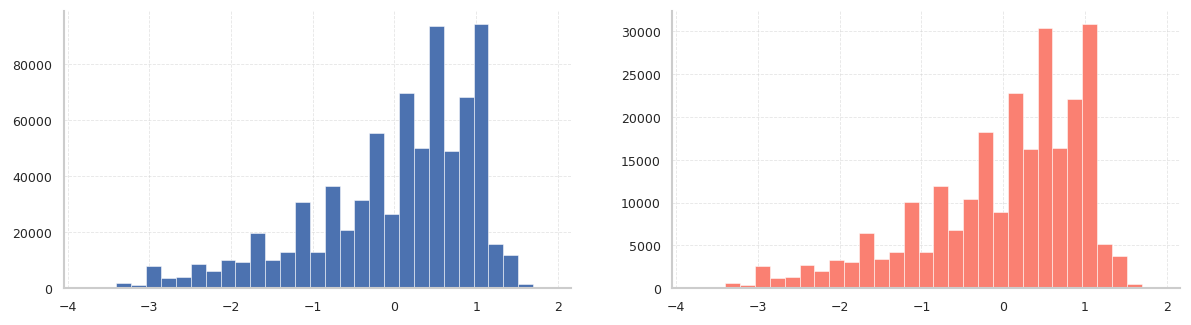

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Body_Temp, bins=31)
ax[1].hist(data.X_test.Body_Temp, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group'] [2, 2, 8]
['Height', 'Weight', 'Heart_Rate', 'Body_Temp', 'BMI', 'Intensity', 'Heart_Duration', 'Weight_Duration_Heart', 'BMI_Age']


In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [ ]:
[4]*2+[2]

[4, 4, 2]

In [ ]:
def tabtransformer(do_rate=0.25, num_cross_layers=2, embedding_dims=4, num_transformer_blocks=3, num_heads=8, mlp_hidden_units_factors=[4]*2+[2]):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    x_input_nums = layers.Input(shape=(len(num_features),))



    # Embedding Cat Features
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], embedding_dims) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        embs.append(x)

    encoded_categorical_features = ops.stack(embs, axis=1)


    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=do_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=do_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(layers.LayerNormalization, epsilon=1e-6),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(x_input_nums)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features], name="concatenate_att_output")

    # Compute MLP hidden_units.
    mlp_hidden_units = [factor * features.shape[-1] for factor in mlp_hidden_units_factors]
    # Create final MLP.
    features = create_mlp(
                          hidden_units=mlp_hidden_units,
                          dropout_rate=do_rate,
                          activation=keras.activations.silu,
                          normalization_layer=layers.BatchNormalization,
                          name="MLP_post_attention",
                         )(features)

    # WIDE Branch of the NN
    embs_cross = []

    for j in embs:
        embs_cross.append(layers.Flatten()(j))

#    embs_cross = layers.Flatten()(embs)
    x1 = layers.Concatenate(axis=-1)(embs_cross+[x_input_nums])

    wide = x1  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x1.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x1, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])


    merged = layers.concatenate([wide, features])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = tabtransformer()
mod_test.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None)            │          0 │ input_layer_12[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None)            │          0 │ input_layer_12[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None)            │          0 │ input_layer_12[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 4)         │          8 │ get_item_6[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 4)         │          8 │ get_item_7[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 4)         │         32 │ get_item_8[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 3, 4)      │          0 │ embedding_6[0][0… │
│                     │                   │            │ embedding_7[0][0… │
│                     │                   │            │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 3, 4)      │        612 │ stack_2[0][0],    │
│ (MultiHeadAttentio… │                   │            │ stack_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection1_0  │ (None, 3, 4)      │          0 │ multihead_attent… │
│ (Add)               │                   │            │ stack_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm1_0       │ (None, 3, 4)      │          8 │ skip_connection1… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feedforward_0       │ (None, 3, 4)      │         28 │ layer_norm1_0[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2_0  │ (None, 3, 4)      │          0 │ feedforward_0[0]… │
│ (Add)               │                   │            │ layer_norm1_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm2_0       │ (None, 3, 4)      │          8 │ skip_connection2… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attentio… │ (None, 3, 4)      │        612 │ layer_norm2_0[0]… │
│ (MultiHeadAttentio… │                   │            │ layer_norm2_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection1_1  │ (None, 3, 4)      │          0 │ multihead_attent… │
│ (Add)               │                   │            │ layer_norm2_0[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,819 (65.70 KB)

 Trainable params: 16,441 (64.22 KB)

 Non-trainable params: 378 (1.48 KB)

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Sex                           765000 non-null  int64
 1   Outliers_Duration_Heart_Temp  765000 non-null  int64
 2   Age_Group                     765000 non-null  int64
dtypes: int64(3)
memory usage: 23.3 MB
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Height                 765000 non-null  float64
 1   Weight                 765000 non-null  float64
 2   Heart_Rate             765000 non-null  float64
 3   Body_Temp              765000 non-null  float64
 4   BMI                    765000 non-null  float64
 5   Intensity              765000 non-null  float64
 6   Heart_Duration         765000 

In [ ]:
y_fin.isna().sum()

,0
Calories,0


**OPTIMIZATION SECTION**

  1. Trial 3 finished with value: 0.06128411016249404 and parameters: {'num_cross_layers': 3, 'do_rate': 0.34650500123999023, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}

  2. rial 22 finished with value: 0.06113841138214773 and parameters: {'num_cross_layers': 3, 'do_rate': 0.3631276829855239, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}.

  3. Trial 7 finished with value: 0.060843740984653075 and parameters: {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=tabtransformer, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

#(num_transformer_blocks=3, num_heads=8, mlp_hidden_units_factors=[4]*2+[2])

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'num_cross_layers': 3, #trial.suggest_int('num_cross_layers', 1, 3),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.40, step=0.01),
              'embedding_dims': 4, #trial.suggest_categorical('embedding_dims', [4, 8]),
              'num_transformer_blocks': trial.suggest_categorical('num_transformer_blocks', [3, 4]),
              'num_heads': trial.suggest_categorical('num_heads', [4, 8, 12]),
              'mlp_hidden_units_factors_0' : trial.suggest_categorical('mlp_hidden_units_factors_0', [2, 3]),
              'mlp_hidden_units_factors_1' : trial.suggest_categorical('mlp_hidden_units_factors_1', [2, 3]),
              'mlp_hidden_units_factors_2' : trial.suggest_categorical('mlp_hidden_units_factors_2', [1, 2]),
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(do_rate=params["do_rate"], num_cross_layers=params["num_cross_layers"], embedding_dims=params["embedding_dims"], num_transformer_blocks=params["num_transformer_blocks"],
                            num_heads=params["num_heads"], mlp_hidden_units_factors=[params["mlp_hidden_units_factors_0"]]*params["mlp_hidden_units_factors_1"]+[params["mlp_hidden_units_factors_2"]])

        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

(Sex                             0
 Height                          0
 Weight                          0
 Heart_Rate                      0
 Body_Temp                       0
 BMI                             0
 Intensity                       0
 Heart_Duration                  0
 Weight_Duration_Heart           0
 Outliers_Duration_Heart_Temp    0
 BMI_Age                         0
 Age_Group                       0
 dtype: int64,
 Calories    1.0
 dtype: float64)

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=tabtransformer, n_trials=27, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

[I 2025-05-10 06:23:34,419] A new study created in memory with name: no-name-fdfe4d0e-4a9f-4e0b-a5f1-19b9cb9dc7e7


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - dense_11_loss: 0.0000e+00 - loss: 2.0126 - msle: 84.2335 - rmsle: 2.0126 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.1112 - val_msle: 11.6258 - val_rmsle: 0.1111 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.1188 - msle: 11.7278 - rmsle: 0.1188 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0761 - val_msle: 5.4061 - val_rmsle: 0.0760 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0787 - msle: 6.5442 - rmsle: 0.0787 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0688 - val_msle: 4.4612 - val_rmsle: 0.0687 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0704 - msle: 5.1670 - rmsle: 0.0704 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0662 - val_msle: 4.1608 - val_rmsle: 0.0661 - learning_rate: 0.0010
Epoch 5/31
598/598 

[I 2025-05-10 06:41:02,841] Trial 0 finished with value: 0.06106129814284443 and parameters: {'do_rate': 0.33999999999999997, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - dense_10_loss: 0.0000e+00 - loss: 1.8231 - msle: 80.5594 - rmsle: 1.8231 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0943 - val_msle: 8.3670 - val_rmsle: 0.0942 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0964 - msle: 8.4309 - rmsle: 0.0964 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0707 - val_msle: 4.6975 - val_rmsle: 0.0707 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0722 - msle: 5.2252 - rmsle: 0.0722 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0667 - val_msle: 4.2618 - val_rmsle: 0.0666 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0677 - msle: 4.5371 - rmsle: 0.0677 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0646 - val_msle: 4.0858 - val_rmsle: 0.0645 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-10 06:56:55,849] Trial 1 finished with value: 0.06135580409070494 and parameters: {'do_rate': 0.35, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - dense_10_loss: 0.0000e+00 - loss: 1.8056 - msle: 79.4219 - rmsle: 1.8056 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0946 - val_msle: 7.9218 - val_rmsle: 0.0946 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0959 - msle: 8.0292 - rmsle: 0.0959 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0701 - val_msle: 4.6720 - val_rmsle: 0.0701 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0730 - msle: 5.2044 - rmsle: 0.0730 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0671 - val_msle: 4.2826 - val_rmsle: 0.0670 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0681 - msle: 4.5260 - rmsle: 0.0681 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0649 - val_msle: 4.0946 - val_rmsle: 0.0648 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-10 07:12:44,236] Trial 2 finished with value: 0.06109477363076846 and parameters: {'do_rate': 0.37, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - dense_11_loss: 0.0000e+00 - loss: 2.1087 - msle: 85.9349 - rmsle: 2.1087 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.1057 - val_msle: 11.0025 - val_rmsle: 0.1057 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_11_loss: 0.0000e+00 - loss: 0.1058 - msle: 10.4071 - rmsle: 0.1058 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0712 - val_msle: 4.9345 - val_rmsle: 0.0711 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0766 - msle: 6.0845 - rmsle: 0.0766 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0663 - val_msle: 4.3367 - val_rmsle: 0.0662 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0696 - msle: 4.9085 - rmsle: 0.0696 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0648 - val_msle: 4.1287 - val_rmsle: 0.0647 - learning_rate: 0.0010
Epoch 5/31
598/598 

[I 2025-05-10 07:31:03,553] Trial 3 finished with value: 0.06110759975077142 and parameters: {'do_rate': 0.38, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - dense_11_loss: 0.0000e+00 - loss: 1.9088 - msle: 83.0224 - rmsle: 1.9088 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0976 - val_msle: 8.7888 - val_rmsle: 0.0976 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0978 - msle: 8.2760 - rmsle: 0.0978 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0711 - val_msle: 4.7716 - val_rmsle: 0.0710 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0740 - msle: 5.3482 - rmsle: 0.0740 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0665 - val_msle: 4.2835 - val_rmsle: 0.0664 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0684 - msle: 4.5966 - rmsle: 0.0684 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0648 - val_msle: 4.1098 - val_rmsle: 0.0647 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-10 07:48:34,779] Trial 4 finished with value: 0.06116618309078449 and parameters: {'do_rate': 0.31, 'num_transformer_blocks': 4, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7605 - msle: 81.0724 - rmsle: 1.7605 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1012 - val_msle: 8.3926 - val_rmsle: 0.1011 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0983 - msle: 8.8222 - rmsle: 0.0983 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0719 - val_msle: 4.8422 - val_rmsle: 0.0718 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0726 - msle: 5.2448 - rmsle: 0.0726 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0674 - val_msle: 4.4178 - val_rmsle: 0.0673 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0675 - msle: 4.4752 - rmsle: 0.0675 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0653 - val_msle: 4.2091 - val_rmsle: 0.0652 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-10 08:03:05,951] Trial 5 finished with value: 0.06149161072527114 and parameters: {'do_rate': 0.36, 'num_transformer_blocks': 3, 'num_heads': 4, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - dense_10_loss: 0.0000e+00 - loss: 1.9738 - msle: 83.4336 - rmsle: 1.9738 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0967 - val_msle: 8.4415 - val_rmsle: 0.0967 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0925 - msle: 7.9384 - rmsle: 0.0925 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0715 - val_msle: 4.7779 - val_rmsle: 0.0715 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0735 - msle: 5.3026 - rmsle: 0.0735 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0669 - val_msle: 4.2686 - val_rmsle: 0.0668 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0685 - msle: 4.5965 - rmsle: 0.0685 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0652 - val_msle: 4.0833 - val_rmsle: 0.0651 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━

[I 2025-05-10 08:20:18,482] Trial 6 finished with value: 0.06125615916261793 and parameters: {'do_rate': 0.33999999999999997, 'num_transformer_blocks': 4, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 0 with value: 0.06106129814284443.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - dense_9_loss: 0.0000e+00 - loss: 1.8254 - msle: 80.9688 - rmsle: 1.8254 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0964 - val_msle: 8.0047 - val_rmsle: 0.0964 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0883 - msle: 7.5681 - rmsle: 0.0883 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0693 - val_msle: 4.5126 - val_rmsle: 0.0692 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0701 - msle: 4.8611 - rmsle: 0.0701 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0651 - val_msle: 4.0758 - val_rmsle: 0.0650 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0666 - msle: 4.3067 - rmsle: 0.0666 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0638 - val_msle: 3.9782 - val_rmsle: 0.0637 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-10 08:35:18,240] Trial 7 finished with value: 0.060843740984653075 and parameters: {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 7 with value: 0.060843740984653075.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - dense_10_loss: 0.0000e+00 - loss: 2.0630 - msle: 84.6985 - rmsle: 2.0630 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.1378 - val_msle: 14.0141 - val_rmsle: 0.1378 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.1376 - msle: 12.5630 - rmsle: 0.1376 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0774 - val_msle: 5.2145 - val_rmsle: 0.0773 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0810 - msle: 6.3133 - rmsle: 0.0810 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0680 - val_msle: 4.4573 - val_rmsle: 0.0679 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_10_loss: 0.0000e+00 - loss: 0.0707 - msle: 4.9763 - rmsle: 0.0707 - val_dense_10_loss: 0.0000e+00 - val_loss: 0.0657 - val_msle: 4.1866 - val_rmsle: 0.0656 - learning_rate: 0.0010
Epoch 5/31
598/598 

[I 2025-05-10 08:51:51,987] Trial 8 finished with value: 0.06117292301513042 and parameters: {'do_rate': 0.32, 'num_transformer_blocks': 4, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 2}. Best is trial 7 with value: 0.060843740984653075.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - dense_11_loss: 0.0000e+00 - loss: 1.8540 - msle: 82.4877 - rmsle: 1.8540 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.1575 - val_msle: 15.1955 - val_rmsle: 0.1575 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.1999 - msle: 19.1862 - rmsle: 0.1999 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0997 - val_msle: 9.1656 - val_rmsle: 0.0996 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dense_11_loss: 0.0000e+00 - loss: 0.1151 - msle: 11.7653 - rmsle: 0.1151 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0724 - val_msle: 5.4371 - val_rmsle: 0.0723 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_11_loss: 0.0000e+00 - loss: 0.0804 - msle: 6.7701 - rmsle: 0.0804 - val_dense_11_loss: 0.0000e+00 - val_loss: 0.0665 - val_msle: 4.4607 - val_rmsle: 0.0664 - learning_rate: 0.0010
Epoch 5/31
598/598

[I 2025-05-10 09:09:15,032] Trial 9 finished with value: 0.06118047627994636 and parameters: {'do_rate': 0.3, 'num_transformer_blocks': 4, 'num_heads': 4, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}. Best is trial 7 with value: 0.060843740984653075.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - dense_9_loss: 0.0000e+00 - loss: 1.8092 - msle: 79.5483 - rmsle: 1.8092 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0949 - val_msle: 7.8874 - val_rmsle: 0.0949 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0912 - msle: 7.8515 - rmsle: 0.0912 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0689 - val_msle: 4.6237 - val_rmsle: 0.0688 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0715 - msle: 5.0710 - rmsle: 0.0715 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0656 - val_msle: 4.1339 - val_rmsle: 0.0655 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0673 - msle: 4.3994 - rmsle: 0.0673 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0643 - val_msle: 3.9776 - val_rmsle: 0.0641 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-10 09:24:09,316] Trial 10 finished with value: 0.06107773242711948 and parameters: {'do_rate': 0.4, 'num_transformer_blocks': 3, 'num_heads': 8, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 7 with value: 0.060843740984653075.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - dense_9_loss: 0.0000e+00 - loss: 1.8202 - msle: 80.0466 - rmsle: 1.8202 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0839 - val_msle: 6.4988 - val_rmsle: 0.0839 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0840 - msle: 6.6771 - rmsle: 0.0840 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0684 - val_msle: 4.4446 - val_rmsle: 0.0683 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0710 - msle: 4.9339 - rmsle: 0.0710 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0653 - val_msle: 4.0939 - val_rmsle: 0.0651 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0672 - msle: 4.3637 - rmsle: 0.0672 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0641 - val_msle: 3.9703 - val_rmsle: 0.0640 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-10 09:39:15,611] Trial 11 finished with value: 0.06099520485007517 and parameters: {'do_rate': 0.32999999999999996, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 7 with value: 0.060843740984653075.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7902 - msle: 79.8571 - rmsle: 1.7902 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1041 - val_msle: 8.7141 - val_rmsle: 0.1041 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0988 - msle: 8.6134 - rmsle: 0.0988 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0707 - val_msle: 4.6633 - val_rmsle: 0.0706 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0721 - msle: 5.1850 - rmsle: 0.0721 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0656 - val_msle: 4.1095 - val_rmsle: 0.0655 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0674 - msle: 4.4161 - rmsle: 0.0674 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0642 - val_msle: 3.9653 - val_rmsle: 0.0641 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

[I 2025-05-10 09:54:07,336] Trial 12 finished with value: 0.0608830146030646 and parameters: {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 8, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}. Best is trial 7 with value: 0.060843740984653075.


Running Fold: 0
Epoch 1/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - dense_9_loss: 0.0000e+00 - loss: 1.7832 - msle: 80.0093 - rmsle: 1.7832 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.1047 - val_msle: 8.7618 - val_rmsle: 0.1047 - learning_rate: 0.0010
Epoch 2/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0969 - msle: 8.5025 - rmsle: 0.0969 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0693 - val_msle: 4.5585 - val_rmsle: 0.0692 - learning_rate: 0.0010
Epoch 3/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0711 - msle: 5.0591 - rmsle: 0.0711 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0653 - val_msle: 4.0736 - val_rmsle: 0.0652 - learning_rate: 0.0010
Epoch 4/31
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - dense_9_loss: 0.0000e+00 - loss: 0.0668 - msle: 4.3515 - rmsle: 0.0668 - val_dense_9_loss: 0.0000e+00 - val_loss: 0.0637 - val_msle: 3.9418 - val_rmsle: 0.0636 - learning_rate: 0.0010
Epoch 5/31
598/598 ━━━━━━━━━━

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param =  {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors': [3,3,1]}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=tabtransformer, parameters=param)

Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - dense_35_loss: 0.0000e+00 - loss: 2.0526 - msle: 85.5027 - rmsle: 2.0526 - val_dense_35_loss: 0.0000e+00 - val_loss: 0.1783 - val_msle: 8.9748 - val_rmsle: 0.1783 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_35_loss: 0.0000e+00 - loss: 0.2225 - msle: 18.8088 - rmsle: 0.2225 - val_dense_35_loss: 0.0000e+00 - val_loss: 0.0873 - val_msle: 6.9820 - val_rmsle: 0.0873 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_35_loss: 0.0000e+00 - loss: 0.1069 - msle: 10.1452 - rmsle: 0.1069 - val_dense_35_loss: 0.0000e+00 - val_loss: 0.0790 - val_msle: 5.9083 - val_rmsle: 0.0789 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_35_loss: 0.0000e+00 - loss: 0.0845 - msle: 7.1493 - rmsle: 0.0845 - val_dense_35_loss: 0.0000e+00 - val_loss: 0.0707 - val_msle: 5.0561 - val_rmsle: 0.0707 - learning_rate: 0.0010
Epoch 5/151
680/680 ━━━━━━━━━━━

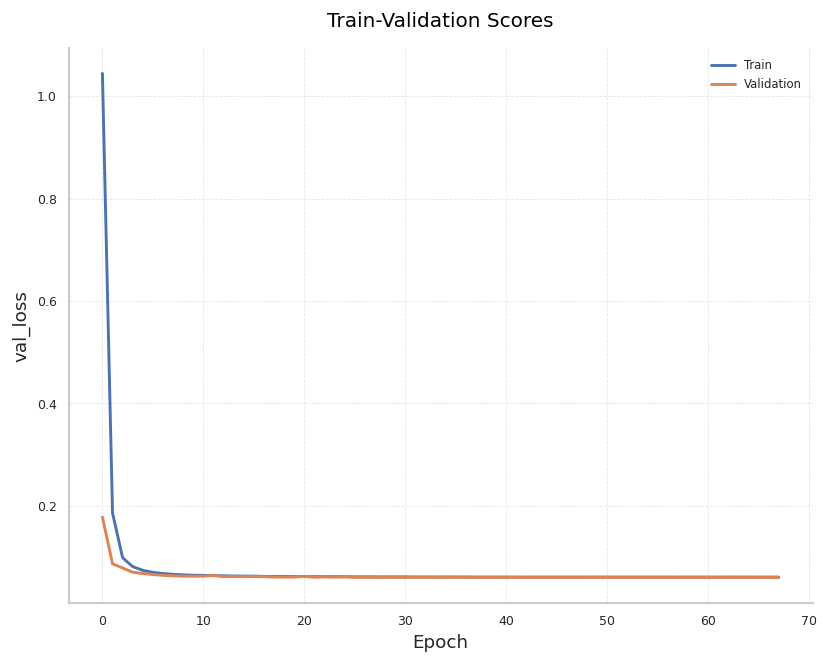

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 1 → Training set Score: 1.36011 | Validation set Score: 0.06139
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - dense_44_loss: 0.0000e+00 - loss: 1.9016 - msle: 83.0538 - rmsle: 1.9016 - val_dense_44_loss: 0.0000e+00 - val_loss: 0.0976 - val_msle: 7.6715 - val_rmsle: 0.0976 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_44_loss: 0.0000e+00 - loss: 0.0925 - msle: 7.4173 - rmsle: 0.0925 - val_dense_44_loss: 0.0000e+00 - val_loss: 0.0720 - val_msle: 4.8599 - val_rmsle: 0.0720 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_44_loss: 0.0000e+00 - loss: 0.0725 - msle: 5.1614 - rmsle: 0.0725 - val_dense_44_loss: 0.0000e+00 - val_loss: 0.0688 - val_msle: 4.4588 - val_rmsle: 0.0688 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_44_loss: 0.0000e+00 - 

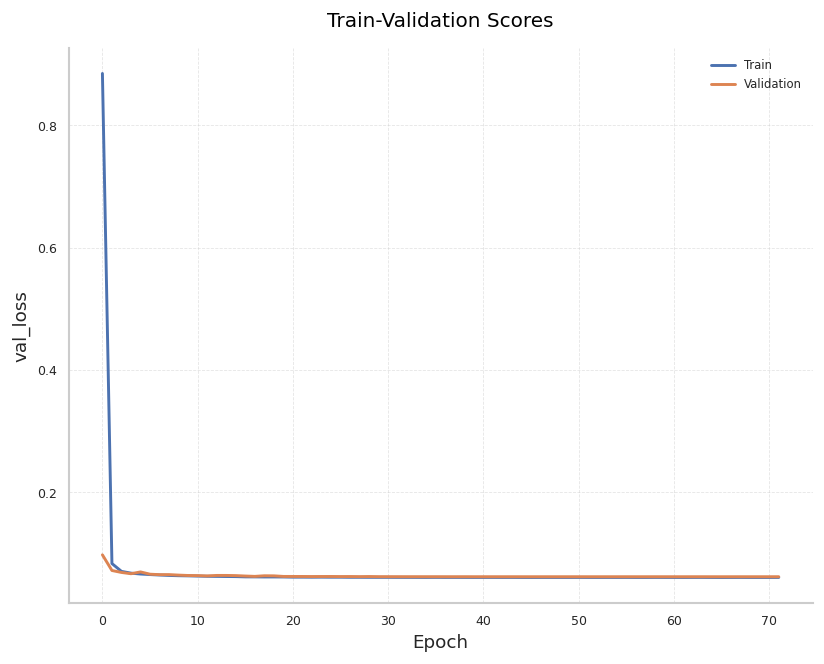

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 2 → Training set Score: 1.36054 | Validation set Score: 0.06261
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - dense_53_loss: 0.0000e+00 - loss: 1.9457 - msle: 84.4540 - rmsle: 1.9456 - val_dense_53_loss: 0.0000e+00 - val_loss: 0.1421 - val_msle: 9.2158 - val_rmsle: 0.1421 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_53_loss: 0.0000e+00 - loss: 0.1460 - msle: 12.0570 - rmsle: 0.1460 - val_dense_53_loss: 0.0000e+00 - val_loss: 0.0807 - val_msle: 5.0620 - val_rmsle: 0.0806 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_53_loss: 0.0000e+00 - loss: 0.0850 - msle: 6.7298 - rmsle: 0.0850 - val_dense_53_loss: 0.0000e+00 - val_loss: 0.0700 - val_msle: 4.5944 - val_rmsle: 0.0700 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - dense_53_loss: 0.0000e+00 -

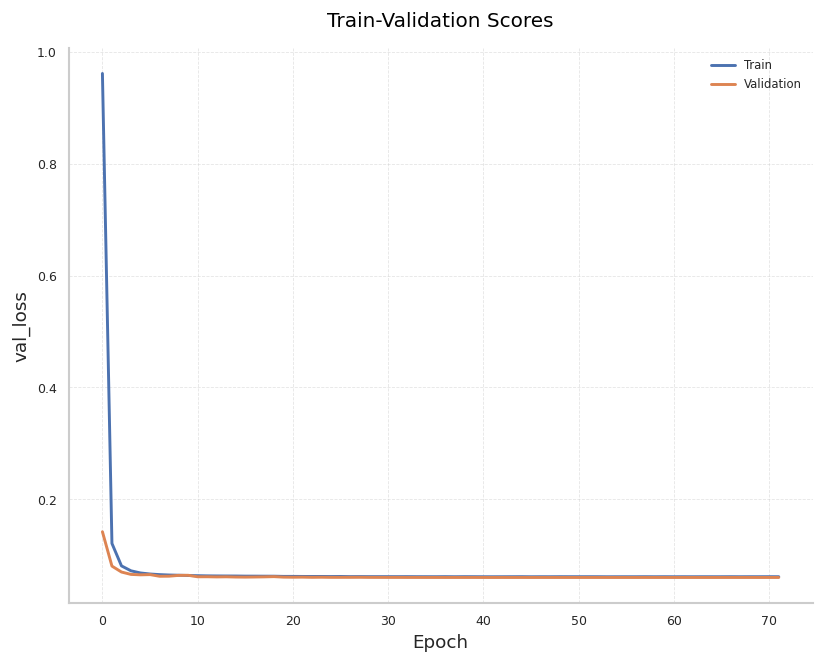

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Fold 3 → Training set Score: 1.36186 | Validation set Score: 0.06091
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - dense_62_loss: 0.0000e+00 - loss: 1.7899 - msle: 82.2302 - rmsle: 1.7899 - val_dense_62_loss: 0.0000e+00 - val_loss: 0.1313 - val_msle: 11.3500 - val_rmsle: 0.1312 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_62_loss: 0.0000e+00 - loss: 0.1258 - msle: 11.2494 - rmsle: 0.1258 - val_dense_62_loss: 0.0000e+00 - val_loss: 0.0776 - val_msle: 5.3055 - val_rmsle: 0.0775 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_62_loss: 0.0000e+00 - loss: 0.0789 - msle: 6.1359 - rmsle: 0.0789 - val_dense_62_loss: 0.0000e+00 - val_loss: 0.0718 - val_msle: 4.8291 - val_rmsle: 0.0718 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_62_loss: 0.0000e+00 

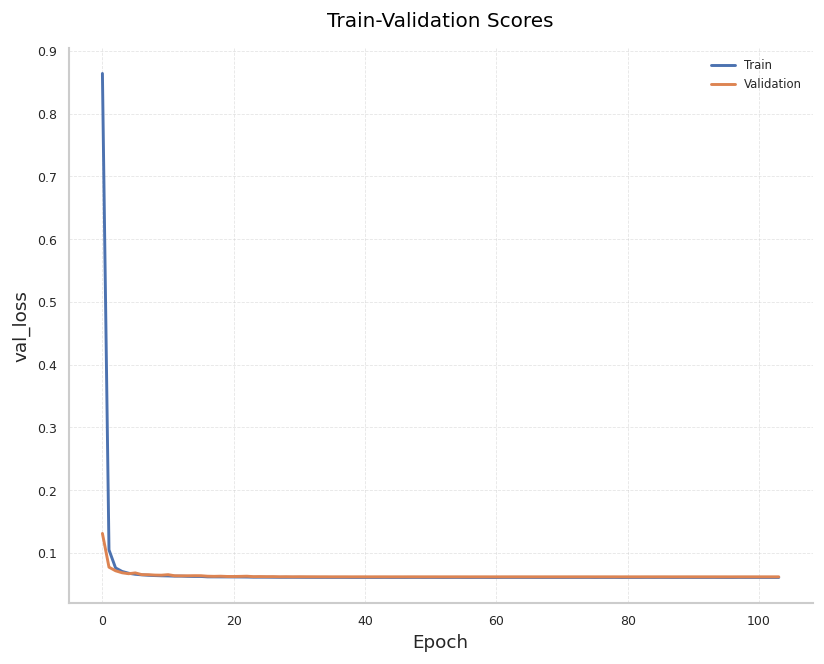

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 4 → Training set Score: 1.36044 | Validation set Score: 0.06297
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - dense_71_loss: 0.0000e+00 - loss: 2.1821 - msle: 86.8654 - rmsle: 2.1821 - val_dense_71_loss: 0.0000e+00 - val_loss: 0.1124 - val_msle: 7.3539 - val_rmsle: 0.1124 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_71_loss: 0.0000e+00 - loss: 0.1175 - msle: 10.2130 - rmsle: 0.1175 - val_dense_71_loss: 0.0000e+00 - val_loss: 0.0725 - val_msle: 4.6564 - val_rmsle: 0.0725 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_71_loss: 0.0000e+00 - loss: 0.0794 - msle: 6.3887 - rmsle: 0.0794 - val_dense_71_loss: 0.0000e+00 - val_loss: 0.0673 - val_msle: 4.2317 - val_rmsle: 0.0673 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_71_loss: 0.0000e+00 -

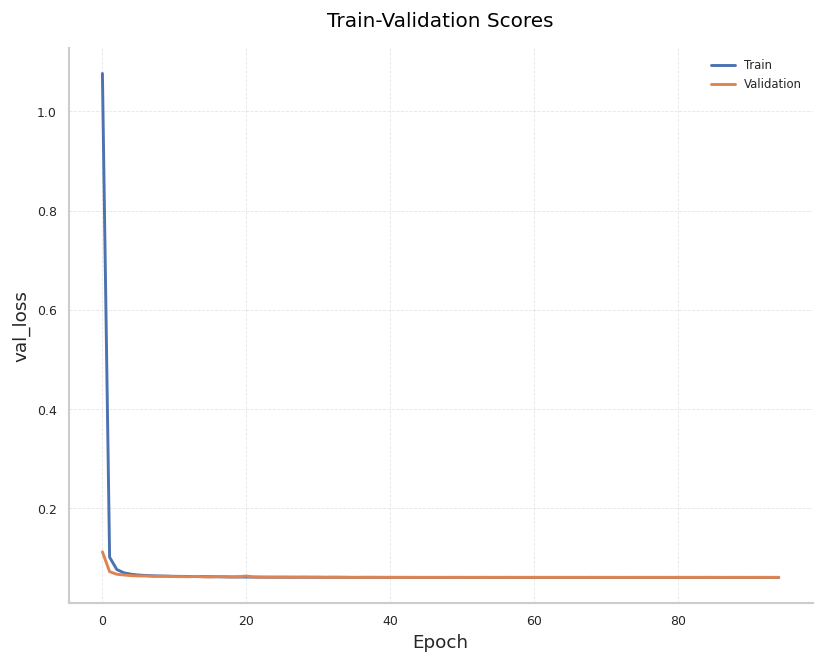

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 5 → Training set Score: 1.36086 | Validation set Score: 0.06186
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - dense_80_loss: 0.0000e+00 - loss: 1.7706 - msle: 82.7065 - rmsle: 1.7706 - val_dense_80_loss: 0.0000e+00 - val_loss: 0.1120 - val_msle: 7.7827 - val_rmsle: 0.1120 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_80_loss: 0.0000e+00 - loss: 0.1052 - msle: 9.0168 - rmsle: 0.1052 - val_dense_80_loss: 0.0000e+00 - val_loss: 0.0874 - val_msle: 5.5481 - val_rmsle: 0.0874 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_80_loss: 0.0000e+00 - loss: 0.0792 - msle: 5.9640 - rmsle: 0.0792 - val_dense_80_loss: 0.0000e+00 - val_loss: 0.0702 - val_msle: 4.6902 - val_rmsle: 0.0702 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_80_loss: 0.0000e+00 - 

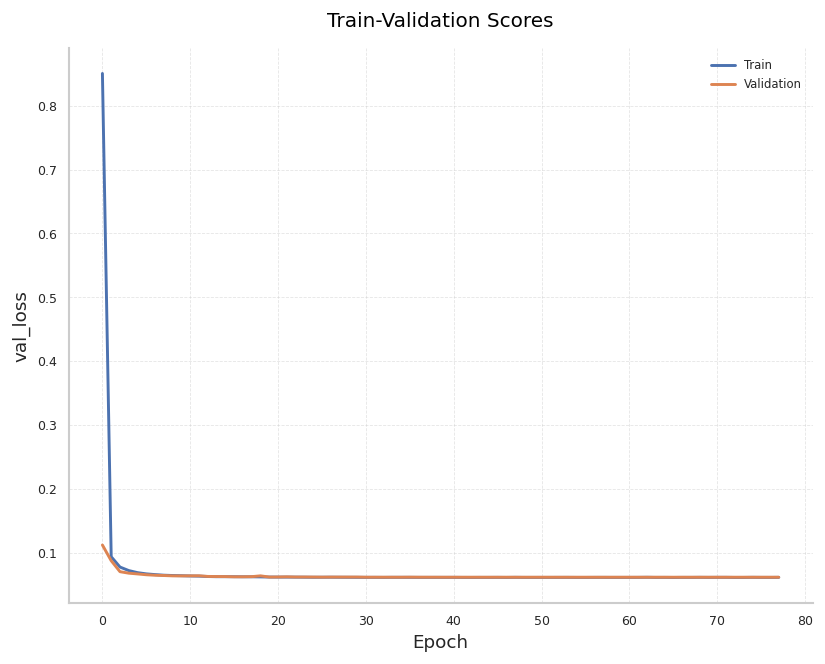

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 6 → Training set Score: 1.36168 | Validation set Score: 0.06203
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - dense_89_loss: 0.0000e+00 - loss: 1.9807 - msle: 82.6078 - rmsle: 1.9807 - val_dense_89_loss: 0.0000e+00 - val_loss: 0.1048 - val_msle: 6.9473 - val_rmsle: 0.1048 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_89_loss: 0.0000e+00 - loss: 0.1154 - msle: 9.4441 - rmsle: 0.1154 - val_dense_89_loss: 0.0000e+00 - val_loss: 0.0700 - val_msle: 4.5289 - val_rmsle: 0.0700 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_89_loss: 0.0000e+00 - loss: 0.0780 - msle: 5.7744 - rmsle: 0.0780 - val_dense_89_loss: 0.0000e+00 - val_loss: 0.0658 - val_msle: 4.2083 - val_rmsle: 0.0658 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_89_loss: 0.0000e+00 - 

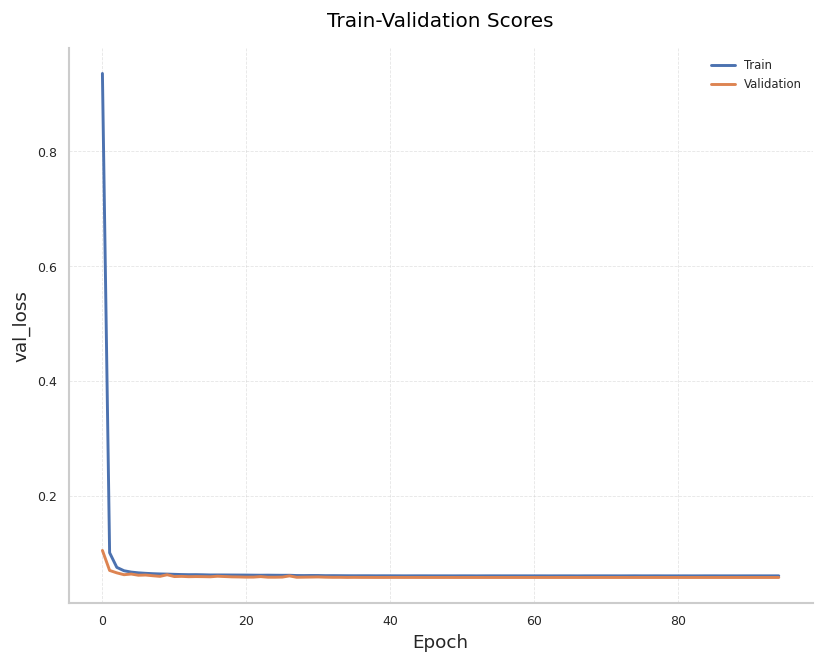

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Fold 7 → Training set Score: 1.36264 | Validation set Score: 0.05820
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - dense_98_loss: 0.0000e+00 - loss: 1.8498 - msle: 82.9223 - rmsle: 1.8498 - val_dense_98_loss: 0.0000e+00 - val_loss: 0.0975 - val_msle: 7.0477 - val_rmsle: 0.0975 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_98_loss: 0.0000e+00 - loss: 0.0943 - msle: 7.2945 - rmsle: 0.0943 - val_dense_98_loss: 0.0000e+00 - val_loss: 0.0733 - val_msle: 5.1310 - val_rmsle: 0.0733 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_98_loss: 0.0000e+00 - loss: 0.0778 - msle: 5.7769 - rmsle: 0.0778 - val_dense_98_loss: 0.0000e+00 - val_loss: 0.0678 - val_msle: 4.6120 - val_rmsle: 0.0678 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - dense_98_loss: 0.0000e+00 - 

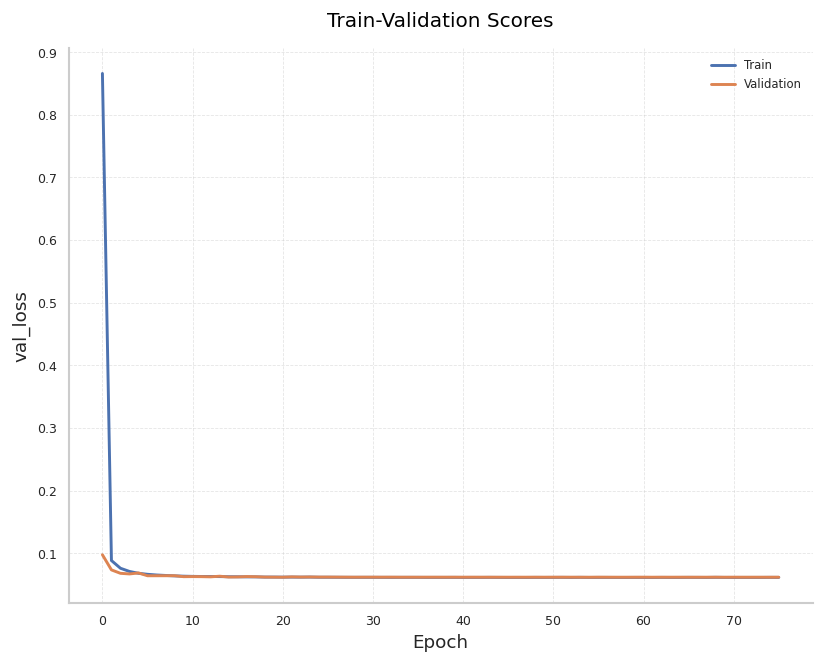

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 8 → Training set Score: 1.36021 | Validation set Score: 0.06227
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - dense_107_loss: 0.0000e+00 - loss: 1.9129 - msle: 85.2472 - rmsle: 1.9129 - val_dense_107_loss: 0.0000e+00 - val_loss: 0.1109 - val_msle: 8.9929 - val_rmsle: 0.1109 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_107_loss: 0.0000e+00 - loss: 0.1039 - msle: 8.8439 - rmsle: 0.1039 - val_dense_107_loss: 0.0000e+00 - val_loss: 0.0775 - val_msle: 4.9783 - val_rmsle: 0.0775 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_107_loss: 0.0000e+00 - loss: 0.0797 - msle: 5.9563 - rmsle: 0.0797 - val_dense_107_loss: 0.0000e+00 - val_loss: 0.0701 - val_msle: 4.6781 - val_rmsle: 0.0701 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_107_loss: 0.0000

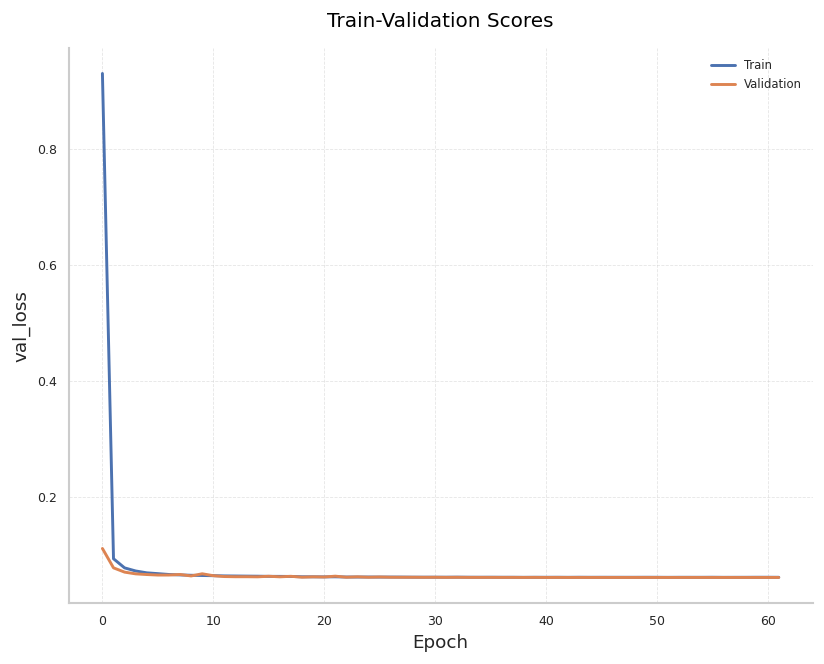

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Fold 9 → Training set Score: 1.36060 | Validation set Score: 0.06164
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - dense_116_loss: 0.0000e+00 - loss: 1.8503 - msle: 82.9587 - rmsle: 1.8503 - val_dense_116_loss: 0.0000e+00 - val_loss: 0.1215 - val_msle: 8.9336 - val_rmsle: 0.1215 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_116_loss: 0.0000e+00 - loss: 0.1306 - msle: 11.3195 - rmsle: 0.1306 - val_dense_116_loss: 0.0000e+00 - val_loss: 0.0791 - val_msle: 5.2353 - val_rmsle: 0.0791 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_116_loss: 0.0000e+00 - loss: 0.0851 - msle: 6.6272 - rmsle: 0.0851 - val_dense_116_loss: 0.0000e+00 - val_loss: 0.0718 - val_msle: 4.7393 - val_rmsle: 0.0717 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_116_loss: 0.000

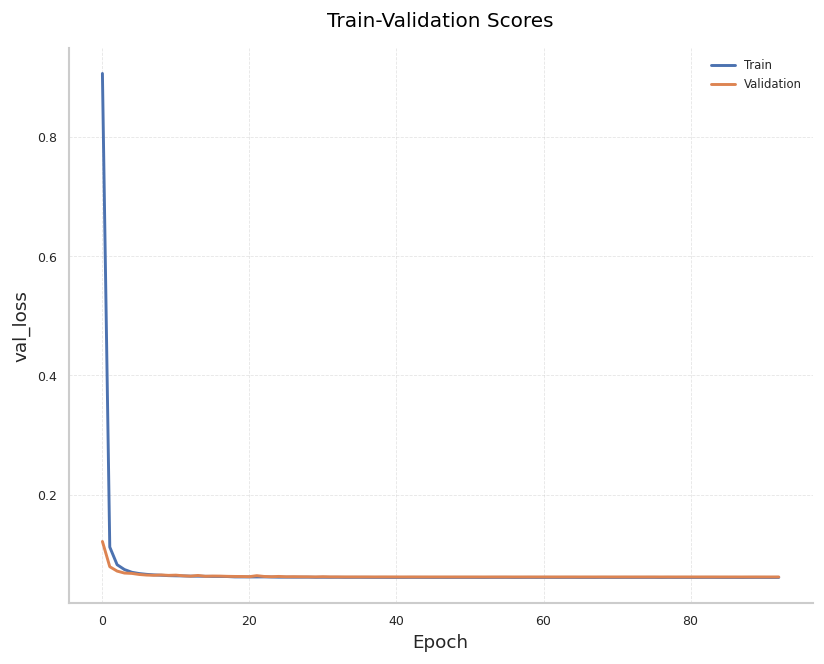

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 10 → Training set Score: 1.36122 | Validation set Score: 0.06277
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - dense_125_loss: 0.0000e+00 - loss: 1.9514 - msle: 84.8658 - rmsle: 1.9514 - val_dense_125_loss: 0.0000e+00 - val_loss: 0.1169 - val_msle: 9.6062 - val_rmsle: 0.1169 - learning_rate: 0.0010
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_125_loss: 0.0000e+00 - loss: 0.1097 - msle: 9.5841 - rmsle: 0.1097 - val_dense_125_loss: 0.0000e+00 - val_loss: 0.0748 - val_msle: 5.2948 - val_rmsle: 0.0748 - learning_rate: 0.0010
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_125_loss: 0.0000e+00 - loss: 0.0769 - msle: 5.7387 - rmsle: 0.0769 - val_dense_125_loss: 0.0000e+00 - val_loss: 0.0696 - val_msle: 4.7283 - val_rmsle: 0.0696 - learning_rate: 0.0010
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - dense_125_loss: 0.000

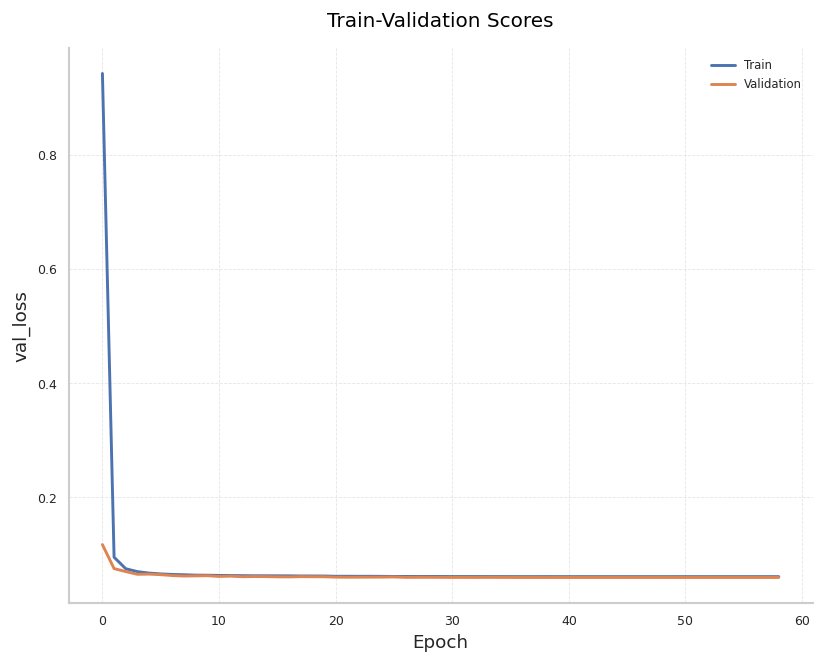

680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 11 → Training set Score: 1.36124 | Validation set Score: 0.05969
Overall → Training set Score: 1.36104±0.0007452 | Validation set Score: 0.06149±0.0013674


In [ ]:
TM.fit_model(name="NN_TabTransformer_00")

#### 2.1.3 Store Results:

In [ ]:
name_experiment = "NN_TabTransformer_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

(NN_TabTransformer_00    1.0
 dtype: float64,
 NN_TabTransformer_00    315.000004
 dtype: float64)

In [ ]:
test_pred.head()

,NN_TabTransformer_00
0,27.325001
1,107.144302
2,86.786153
3,126.078431
4,75.644506


In [ ]:
sub.head()

,Calories
id,
750000,27.325001
750001,107.144302
750002,86.786153
750003,126.078431
750004,75.644506


In [ ]:
train_pred.head()

,NN_TabTransformer_00
0,145.587036
1,36.013367
2,29.129110
3,137.517090
4,146.211304


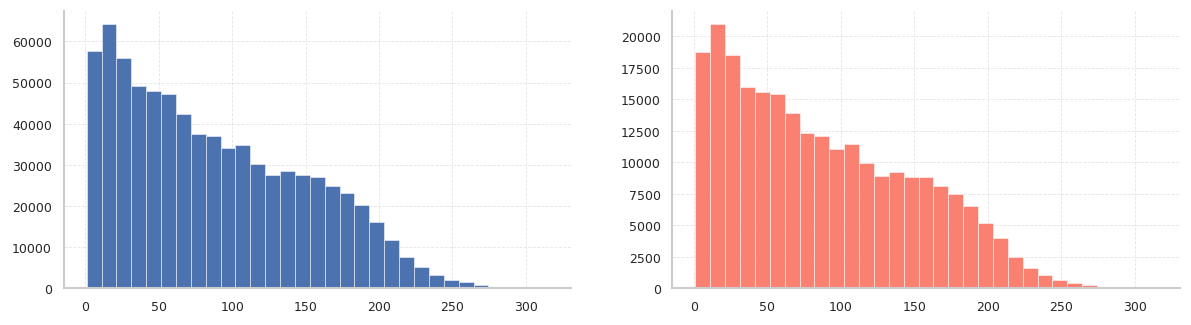

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

## **3.0 TREE BASED MODELS**

In [18]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
# class_weights = dict(enumerate(class_weights))

# sample_pos_weight = class_weights[1]/class_weights[0]
# sample_pos_weight

#### 4.1.1 CatBoostClassifier:

In [19]:
cat_prob = {"objective":"RMSE","eval_metric":"RMSE"}

In [20]:
X = data.X
y = np.log(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']

##### 4.1.2 Optuna Optimization:

In [21]:
def objective_catboost(trial, X, y, n_splits, n_repeats, model=CatBoostRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=cat_prob,categorical_features=categorical_features):

    model_class = model

    categorical_features = categorical_features

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'iterations': 1500,
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 5, 11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 0.1, log=True),
        "bootstrap_type": "Bayesian",
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.5, step=0.1),
        'random_strength': trial.suggest_float('random_strength', 0.5, 3.5, step=0.25),
        #'border_count': trial.suggest_int('border_count', 32, 255),
        'cat_features': categorical_features,
        'task_type': 'GPU' if use_gpu else 'CPU',
        'random_seed':rs,
        'verbose': 250,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', #Early stopping hyperparmeter
        "od_wait":101,
        #"sampling_frequency":"PerTreeLevel",
        "use_best_model":True,
    }

    if cv_strategy == 'RepKFold':
      kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
      kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
      kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
      kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1,1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1,1)

        if fit_scaling:
          scaler = StandardScaler()
          X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
          X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the Pool objects for CatBoost
        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
        valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

        # Create the pipeline
        model = model_class(**params)
        # Fit the model:
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
                  #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
                  )

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

#        y_pred = np.expm1(y_pred)
#        y_valid = np.expm1(y_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

        gc.collect()

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [22]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_catboost(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

In [23]:
# usage with XGBRegressor
cat_study = tune_hyperparameters(X, y, model_class=CatBoostRegressor, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, CatBoostRegressor, "CatBoost_ext")

[I 2025-05-11 22:52:25,786] A new study created in memory with name: no-name-527b4f4a-5845-4292-8beb-77bd8904b456


0:	learn: 0.9844177	test: 0.9816218	best: 0.9816218 (0)	total: 20.2ms	remaining: 30.3s
250:	learn: 0.0753483	test: 0.0753780	best: 0.0753780 (250)	total: 3.32s	remaining: 16.5s
500:	learn: 0.0691517	test: 0.0701308	best: 0.0701308 (500)	total: 6.64s	remaining: 13.3s
750:	learn: 0.0676447	test: 0.0691695	best: 0.0691695 (750)	total: 10.1s	remaining: 10s
1000:	learn: 0.0667801	test: 0.0687345	best: 0.0687345 (1000)	total: 13.3s	remaining: 6.61s
1250:	learn: 0.0661196	test: 0.0684997	best: 0.0684997 (1250)	total: 16.4s	remaining: 3.27s
1499:	learn: 0.0656008	test: 0.0683516	best: 0.0683516 (1499)	total: 19.6s	remaining: 0us
bestTest = 0.06835161166
bestIteration = 1499
0:	learn: 0.9834413	test: 0.9855677	best: 0.9855677 (0)	total: 13.4ms	remaining: 20s
250:	learn: 0.0758761	test: 0.0760632	best: 0.0760632 (250)	total: 3.15s	remaining: 15.7s
500:	learn: 0.0693494	test: 0.0704362	best: 0.0704362 (500)	total: 6.3s	remaining: 12.6s
750:	learn: 0.0678066	test: 0.0694353	best: 0.0694353 (750)	t

[I 2025-05-11 22:54:09,812] Trial 0 finished with value: 0.06811673411403549 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0612597915860475, 'bagging_temperature': 0.8, 'random_strength': 0.75}. Best is trial 0 with value: 0.06811673411403549.


0:	learn: 0.9842979	test: 0.9815118	best: 0.9815118 (0)	total: 25.8ms	remaining: 38.7s
250:	learn: 0.0708590	test: 0.0716608	best: 0.0716608 (250)	total: 5.76s	remaining: 28.7s
500:	learn: 0.0669432	test: 0.0690545	best: 0.0690545 (500)	total: 11.6s	remaining: 23.1s
750:	learn: 0.0653833	test: 0.0685513	best: 0.0685512 (748)	total: 17.5s	remaining: 17.4s
1000:	learn: 0.0642243	test: 0.0683696	best: 0.0683696 (1000)	total: 23.4s	remaining: 11.7s
1250:	learn: 0.0632230	test: 0.0683149	best: 0.0683112 (1211)	total: 29.3s	remaining: 5.83s
1499:	learn: 0.0623989	test: 0.0682718	best: 0.0682710 (1496)	total: 35.1s	remaining: 0us
bestTest = 0.06827099358
bestIteration = 1496
Shrink model to first 1497 iterations.
0:	learn: 0.9834281	test: 0.9855485	best: 0.9855485 (0)	total: 23.9ms	remaining: 35.9s
250:	learn: 0.0710751	test: 0.0720980	best: 0.0720980 (250)	total: 5.73s	remaining: 28.5s
500:	learn: 0.0670144	test: 0.0691468	best: 0.0691468 (500)	total: 11.5s	remaining: 22.9s
750:	learn: 0.065

[I 2025-05-11 22:57:12,329] Trial 1 finished with value: 0.0679649920155518 and parameters: {'depth': 10, 'l2_leaf_reg': 0.00010575915555333654, 'bagging_temperature': 1.1, 'random_strength': 2.75}. Best is trial 1 with value: 0.0679649920155518.


0:	learn: 0.9850008	test: 0.9822080	best: 0.9822080 (0)	total: 9.78ms	remaining: 14.7s
250:	learn: 0.0824612	test: 0.0820216	best: 0.0820216 (250)	total: 2.22s	remaining: 11.1s
500:	learn: 0.0722269	test: 0.0725671	best: 0.0725671 (500)	total: 4.38s	remaining: 8.73s
750:	learn: 0.0701590	test: 0.0708497	best: 0.0708497 (750)	total: 6.55s	remaining: 6.54s
1000:	learn: 0.0690260	test: 0.0700062	best: 0.0700062 (1000)	total: 8.74s	remaining: 4.36s
1250:	learn: 0.0682418	test: 0.0694709	best: 0.0694709 (1250)	total: 10.9s	remaining: 2.18s
1499:	learn: 0.0676773	test: 0.0691351	best: 0.0691351 (1499)	total: 13.1s	remaining: 0us
bestTest = 0.06913512767
bestIteration = 1499
0:	learn: 0.9840204	test: 0.9861436	best: 0.9861436 (0)	total: 9.59ms	remaining: 14.4s
250:	learn: 0.0829463	test: 0.0828136	best: 0.0828136 (250)	total: 2.21s	remaining: 11s
500:	learn: 0.0725071	test: 0.0728417	best: 0.0728417 (500)	total: 4.41s	remaining: 8.79s
750:	learn: 0.0703233	test: 0.0711074	best: 0.0711074 (750

[I 2025-05-11 22:58:26,430] Trial 2 finished with value: 0.06894145441349989 and parameters: {'depth': 5, 'l2_leaf_reg': 0.00024002652773829006, 'bagging_temperature': 0.6, 'random_strength': 3.0}. Best is trial 1 with value: 0.0679649920155518.


0:	learn: 0.9842949	test: 0.9815052	best: 0.9815052 (0)	total: 19.2ms	remaining: 28.7s
250:	learn: 0.0716922	test: 0.0722596	best: 0.0722596 (250)	total: 4.64s	remaining: 23.1s
500:	learn: 0.0673125	test: 0.0690715	best: 0.0690715 (500)	total: 9.27s	remaining: 18.5s
750:	learn: 0.0658916	test: 0.0684913	best: 0.0684913 (750)	total: 13.9s	remaining: 13.9s
1000:	learn: 0.0649106	test: 0.0682625	best: 0.0682625 (1000)	total: 18.6s	remaining: 9.27s
1250:	learn: 0.0640829	test: 0.0681575	best: 0.0681572 (1249)	total: 23.3s	remaining: 4.64s
1499:	learn: 0.0634087	test: 0.0680915	best: 0.0680896 (1492)	total: 28s	remaining: 0us
bestTest = 0.06808961274
bestIteration = 1492
Shrink model to first 1493 iterations.
0:	learn: 0.9833623	test: 0.9854953	best: 0.9854953 (0)	total: 19ms	remaining: 28.5s
250:	learn: 0.0718703	test: 0.0727353	best: 0.0727353 (250)	total: 4.64s	remaining: 23.1s
500:	learn: 0.0674495	test: 0.0694206	best: 0.0694206 (500)	total: 9.25s	remaining: 18.4s
750:	learn: 0.0659571

[I 2025-05-11 23:00:54,687] Trial 3 finished with value: 0.06784843437252085 and parameters: {'depth': 9, 'l2_leaf_reg': 0.01144316195368721, 'bagging_temperature': 1.0, 'random_strength': 0.5}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9843010	test: 0.9815149	best: 0.9815149 (0)	total: 18.9ms	remaining: 28.3s
250:	learn: 0.0719765	test: 0.0725668	best: 0.0725668 (250)	total: 4.53s	remaining: 22.5s
500:	learn: 0.0677039	test: 0.0694008	best: 0.0694008 (500)	total: 9.19s	remaining: 18.3s
750:	learn: 0.0662727	test: 0.0687837	best: 0.0687837 (750)	total: 13.8s	remaining: 13.8s
1000:	learn: 0.0652810	test: 0.0685209	best: 0.0685209 (1000)	total: 18.5s	remaining: 9.23s
1250:	learn: 0.0644615	test: 0.0684132	best: 0.0684132 (1250)	total: 23.2s	remaining: 4.62s
1499:	learn: 0.0637720	test: 0.0683591	best: 0.0683530 (1458)	total: 27.8s	remaining: 0us
bestTest = 0.06835300361
bestIteration = 1458
Shrink model to first 1459 iterations.
0:	learn: 0.9834300	test: 0.9855508	best: 0.9855508 (0)	total: 18.8ms	remaining: 28.2s
250:	learn: 0.0723625	test: 0.0730306	best: 0.0730306 (250)	total: 4.58s	remaining: 22.8s
500:	learn: 0.0678287	test: 0.0696777	best: 0.0696777 (500)	total: 9.12s	remaining: 18.2s
750:	learn: 0.066

[I 2025-05-11 23:03:22,795] Trial 4 finished with value: 0.06804919334072346 and parameters: {'depth': 9, 'l2_leaf_reg': 0.003125441906136151, 'bagging_temperature': 1.3, 'random_strength': 3.0}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9843010	test: 0.9815149	best: 0.9815149 (0)	total: 18.9ms	remaining: 28.3s
250:	learn: 0.0719115	test: 0.0725221	best: 0.0725221 (250)	total: 4.63s	remaining: 23s
500:	learn: 0.0676038	test: 0.0692861	best: 0.0692861 (500)	total: 9.22s	remaining: 18.4s
750:	learn: 0.0661417	test: 0.0686611	best: 0.0686611 (750)	total: 13.8s	remaining: 13.8s
1000:	learn: 0.0651167	test: 0.0683880	best: 0.0683880 (1000)	total: 18.5s	remaining: 9.23s
1250:	learn: 0.0642619	test: 0.0682456	best: 0.0682456 (1250)	total: 23.2s	remaining: 4.62s
1499:	learn: 0.0635376	test: 0.0681785	best: 0.0681785 (1499)	total: 27.9s	remaining: 0us
bestTest = 0.06817847358
bestIteration = 1499
0:	learn: 0.9834064	test: 0.9855350	best: 0.9855350 (0)	total: 19.4ms	remaining: 29.1s
250:	learn: 0.0721850	test: 0.0730171	best: 0.0730171 (250)	total: 4.65s	remaining: 23.1s
500:	learn: 0.0678206	test: 0.0696265	best: 0.0696265 (500)	total: 9.28s	remaining: 18.5s
750:	learn: 0.0663533	test: 0.0688811	best: 0.0688811 (750

[I 2025-05-11 23:05:51,223] Trial 5 finished with value: 0.06789747767254553 and parameters: {'depth': 9, 'l2_leaf_reg': 0.0011391337455928477, 'bagging_temperature': 0.6, 'random_strength': 2.75}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9843010	test: 0.9815149	best: 0.9815149 (0)	total: 19ms	remaining: 28.5s
250:	learn: 0.0719157	test: 0.0724701	best: 0.0724701 (250)	total: 4.55s	remaining: 22.6s
500:	learn: 0.0676732	test: 0.0694006	best: 0.0694006 (500)	total: 9.13s	remaining: 18.2s
750:	learn: 0.0662384	test: 0.0687815	best: 0.0687815 (750)	total: 13.8s	remaining: 13.8s
1000:	learn: 0.0652525	test: 0.0685558	best: 0.0685558 (1000)	total: 18.5s	remaining: 9.23s
1250:	learn: 0.0644544	test: 0.0684564	best: 0.0684564 (1250)	total: 23.1s	remaining: 4.61s
1499:	learn: 0.0637874	test: 0.0683927	best: 0.0683905 (1486)	total: 27.9s	remaining: 0us
bestTest = 0.06839048808
bestIteration = 1486
Shrink model to first 1487 iterations.
0:	learn: 0.9833469	test: 0.9854743	best: 0.9854743 (0)	total: 19.4ms	remaining: 29.1s
250:	learn: 0.0722617	test: 0.0729723	best: 0.0729723 (250)	total: 4.62s	remaining: 23s
500:	learn: 0.0677854	test: 0.0695599	best: 0.0695599 (500)	total: 9.23s	remaining: 18.4s
750:	learn: 0.0663102

[I 2025-05-11 23:08:19,508] Trial 6 finished with value: 0.06806230917745854 and parameters: {'depth': 9, 'l2_leaf_reg': 0.001790849303535836, 'bagging_temperature': 1.5, 'random_strength': 2.5}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9843757	test: 0.9815736	best: 0.9815736 (0)	total: 15.4ms	remaining: 23.1s
250:	learn: 0.0730937	test: 0.0733985	best: 0.0733985 (250)	total: 3.75s	remaining: 18.7s
500:	learn: 0.0682360	test: 0.0695932	best: 0.0695932 (500)	total: 7.51s	remaining: 15s
750:	learn: 0.0667909	test: 0.0688239	best: 0.0688239 (750)	total: 11.3s	remaining: 11.3s
1000:	learn: 0.0659134	test: 0.0685195	best: 0.0685195 (1000)	total: 15.1s	remaining: 7.54s
1250:	learn: 0.0652294	test: 0.0683444	best: 0.0683444 (1248)	total: 18.9s	remaining: 3.77s
1499:	learn: 0.0646545	test: 0.0682476	best: 0.0682465 (1495)	total: 22.7s	remaining: 0us
bestTest = 0.06824654408
bestIteration = 1495
Shrink model to first 1496 iterations.
0:	learn: 0.9834001	test: 0.9855323	best: 0.9855323 (0)	total: 16ms	remaining: 23.9s
250:	learn: 0.0735720	test: 0.0740729	best: 0.0740729 (250)	total: 3.78s	remaining: 18.8s
500:	learn: 0.0684354	test: 0.0699373	best: 0.0699373 (500)	total: 7.54s	remaining: 15s
750:	learn: 0.0669613	t

[I 2025-05-11 23:10:21,765] Trial 7 finished with value: 0.06803508650110474 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0008264682183360436, 'bagging_temperature': 1.2000000000000002, 'random_strength': 0.75}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9842979	test: 0.9815118	best: 0.9815118 (0)	total: 23.6ms	remaining: 35.4s
250:	learn: 0.0706932	test: 0.0715407	best: 0.0715407 (250)	total: 5.75s	remaining: 28.6s
500:	learn: 0.0668461	test: 0.0690334	best: 0.0690334 (500)	total: 11.6s	remaining: 23.1s
750:	learn: 0.0653022	test: 0.0685961	best: 0.0685961 (750)	total: 17.4s	remaining: 17.4s
1000:	learn: 0.0641453	test: 0.0684056	best: 0.0684056 (1000)	total: 23.4s	remaining: 11.7s
1250:	learn: 0.0631960	test: 0.0683289	best: 0.0683241 (1236)	total: 29.3s	remaining: 5.83s
1499:	learn: 0.0623682	test: 0.0683011	best: 0.0682997 (1496)	total: 35.2s	remaining: 0us
bestTest = 0.06829973034
bestIteration = 1496
Shrink model to first 1497 iterations.
0:	learn: 0.9833450	test: 0.9854715	best: 0.9854715 (0)	total: 23.6ms	remaining: 35.3s
250:	learn: 0.0709545	test: 0.0720449	best: 0.0720449 (250)	total: 5.75s	remaining: 28.6s
500:	learn: 0.0669079	test: 0.0691297	best: 0.0691297 (500)	total: 11.6s	remaining: 23.1s
750:	learn: 0.065

[I 2025-05-11 23:13:20,923] Trial 8 finished with value: 0.06793081108493441 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0004967828039552079, 'bagging_temperature': 1.2000000000000002, 'random_strength': 2.25}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9842675	test: 0.9814629	best: 0.9814629 (0)	total: 32.2ms	remaining: 48.2s
250:	learn: 0.0696230	test: 0.0707779	best: 0.0707779 (250)	total: 7.63s	remaining: 38s
500:	learn: 0.0659295	test: 0.0687277	best: 0.0687277 (500)	total: 15.5s	remaining: 30.9s
750:	learn: 0.0642230	test: 0.0684172	best: 0.0684172 (750)	total: 23.4s	remaining: 23.3s
1000:	learn: 0.0629364	test: 0.0683521	best: 0.0683510 (968)	total: 31.2s	remaining: 15.5s
1250:	learn: 0.0618463	test: 0.0683310	best: 0.0683237 (1178)	total: 39.2s	remaining: 7.8s
1499:	learn: 0.0608978	test: 0.0683254	best: 0.0683155 (1438)	total: 47.2s	remaining: 0us
bestTest = 0.06831545187
bestIteration = 1438
Shrink model to first 1439 iterations.
0:	learn: 0.9832982	test: 0.9854262	best: 0.9854262 (0)	total: 31.5ms	remaining: 47.2s
250:	learn: 0.0697481	test: 0.0711591	best: 0.0711591 (250)	total: 7.65s	remaining: 38.1s
500:	learn: 0.0659972	test: 0.0688244	best: 0.0688244 (500)	total: 15.5s	remaining: 30.8s
750:	learn: 0.0642965

[I 2025-05-11 23:17:18,485] Trial 9 finished with value: 0.06787263828013908 and parameters: {'depth': 11, 'l2_leaf_reg': 0.03280681981204937, 'bagging_temperature': 1.3, 'random_strength': 1.0}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9844761	test: 0.9816842	best: 0.9816842 (0)	total: 13.1ms	remaining: 19.7s
250:	learn: 0.0752868	test: 0.0753181	best: 0.0753181 (250)	total: 3.15s	remaining: 15.7s
500:	learn: 0.0692987	test: 0.0702185	best: 0.0702185 (500)	total: 6.35s	remaining: 12.7s
750:	learn: 0.0677426	test: 0.0692026	best: 0.0692026 (750)	total: 9.49s	remaining: 9.46s
1000:	learn: 0.0668593	test: 0.0687566	best: 0.0687566 (1000)	total: 12.6s	remaining: 6.3s
1250:	learn: 0.0662006	test: 0.0685129	best: 0.0685123 (1249)	total: 15.8s	remaining: 3.14s
1499:	learn: 0.0656764	test: 0.0683546	best: 0.0683546 (1499)	total: 19s	remaining: 0us
bestTest = 0.06835459104
bestIteration = 1499
0:	learn: 0.9834991	test: 0.9856187	best: 0.9856187 (0)	total: 13ms	remaining: 19.5s
250:	learn: 0.0758166	test: 0.0759922	best: 0.0759922 (250)	total: 3.16s	remaining: 15.7s
500:	learn: 0.0694253	test: 0.0704822	best: 0.0704822 (500)	total: 6.28s	remaining: 12.5s
750:	learn: 0.0678281	test: 0.0694650	best: 0.0694650 (750)	t

[I 2025-05-11 23:19:01,598] Trial 10 finished with value: 0.06815514047781698 and parameters: {'depth': 7, 'l2_leaf_reg': 0.013171320275594891, 'bagging_temperature': 0.9, 'random_strength': 1.5}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9842856	test: 0.9814999	best: 0.9814999 (0)	total: 31.8ms	remaining: 47.6s
250:	learn: 0.0697328	test: 0.0708437	best: 0.0708437 (250)	total: 7.62s	remaining: 37.9s
500:	learn: 0.0659917	test: 0.0687713	best: 0.0687713 (500)	total: 15.4s	remaining: 30.7s
750:	learn: 0.0643039	test: 0.0684654	best: 0.0684654 (750)	total: 23.2s	remaining: 23.2s
1000:	learn: 0.0630086	test: 0.0683483	best: 0.0683468 (995)	total: 31s	remaining: 15.5s
1250:	learn: 0.0619509	test: 0.0683459	best: 0.0683408 (1186)	total: 38.9s	remaining: 7.74s
bestTest = 0.06834077566
bestIteration = 1186
Shrink model to first 1187 iterations.
0:	learn: 0.9833545	test: 0.9854830	best: 0.9854830 (0)	total: 31.2ms	remaining: 46.8s
250:	learn: 0.0699618	test: 0.0714024	best: 0.0714024 (250)	total: 7.73s	remaining: 38.5s
500:	learn: 0.0661288	test: 0.0690229	best: 0.0690229 (500)	total: 15.5s	remaining: 30.9s
750:	learn: 0.0644118	test: 0.0686178	best: 0.0686178 (750)	total: 23.3s	remaining: 23.2s
1000:	learn: 0.06310

[I 2025-05-11 23:22:43,483] Trial 11 finished with value: 0.06799169627284937 and parameters: {'depth': 11, 'l2_leaf_reg': 0.02314508524437585, 'bagging_temperature': 1.5, 'random_strength': 1.5}. Best is trial 3 with value: 0.06784843437252085.


0:	learn: 0.9841627	test: 0.9813702	best: 0.9813702 (0)	total: 31.4ms	remaining: 47.1s
250:	learn: 0.0695900	test: 0.0707232	best: 0.0707232 (250)	total: 7.71s	remaining: 38.4s
500:	learn: 0.0658107	test: 0.0686872	best: 0.0686872 (500)	total: 15.5s	remaining: 30.8s
750:	learn: 0.0641078	test: 0.0683336	best: 0.0683336 (750)	total: 23.2s	remaining: 23.2s
1000:	learn: 0.0628346	test: 0.0682182	best: 0.0682180 (998)	total: 31.1s	remaining: 15.5s
1250:	learn: 0.0616896	test: 0.0682178	best: 0.0682086 (1158)	total: 38.9s	remaining: 7.75s
bestTest = 0.06820861498
bestIteration = 1158
Shrink model to first 1159 iterations.
0:	learn: 0.9832336	test: 0.9853540	best: 0.9853540 (0)	total: 31.1ms	remaining: 46.6s
250:	learn: 0.0697356	test: 0.0711483	best: 0.0711483 (250)	total: 7.67s	remaining: 38.2s
500:	learn: 0.0658519	test: 0.0688342	best: 0.0688342 (500)	total: 15.5s	remaining: 30.9s
750:	learn: 0.0641525	test: 0.0684641	best: 0.0684641 (750)	total: 23.3s	remaining: 23.3s
1000:	learn: 0.062

[I 2025-05-11 23:26:17,507] Trial 12 finished with value: 0.06780814045201593 and parameters: {'depth': 11, 'l2_leaf_reg': 0.011432299090505017, 'bagging_temperature': 1.0, 'random_strength': 0.5}. Best is trial 12 with value: 0.06780814045201593.


0:	learn: 0.9841627	test: 0.9813702	best: 0.9813702 (0)	total: 30.9ms	remaining: 46.4s
250:	learn: 0.0695936	test: 0.0706970	best: 0.0706970 (250)	total: 7.67s	remaining: 38.2s
500:	learn: 0.0657948	test: 0.0685815	best: 0.0685811 (499)	total: 15.5s	remaining: 31s
750:	learn: 0.0641041	test: 0.0682625	best: 0.0682625 (750)	total: 23.3s	remaining: 23.3s
1000:	learn: 0.0627947	test: 0.0681413	best: 0.0681402 (998)	total: 31.3s	remaining: 15.6s
1250:	learn: 0.0616501	test: 0.0681085	best: 0.0681058 (1218)	total: 39.3s	remaining: 7.83s
bestTest = 0.06810579572
bestIteration = 1218
Shrink model to first 1219 iterations.
0:	learn: 0.9832285	test: 0.9853655	best: 0.9853655 (0)	total: 31.6ms	remaining: 47.4s
250:	learn: 0.0696262	test: 0.0711171	best: 0.0711171 (250)	total: 7.72s	remaining: 38.4s
500:	learn: 0.0658467	test: 0.0688193	best: 0.0688193 (500)	total: 15.6s	remaining: 31.1s
750:	learn: 0.0641697	test: 0.0684447	best: 0.0684447 (750)	total: 23.4s	remaining: 23.3s
1000:	learn: 0.06283

[I 2025-05-11 23:30:10,081] Trial 13 finished with value: 0.06775561622925955 and parameters: {'depth': 11, 'l2_leaf_reg': 0.009910906482146868, 'bagging_temperature': 0.9, 'random_strength': 0.5}. Best is trial 13 with value: 0.06775561622925955.


0:	learn: 0.9842855	test: 0.9814999	best: 0.9814999 (0)	total: 30.7ms	remaining: 46s
250:	learn: 0.0697407	test: 0.0708682	best: 0.0708682 (250)	total: 7.66s	remaining: 38.1s
500:	learn: 0.0659912	test: 0.0687413	best: 0.0687413 (500)	total: 15.4s	remaining: 30.6s
750:	learn: 0.0643054	test: 0.0683862	best: 0.0683862 (750)	total: 23.2s	remaining: 23.1s
1000:	learn: 0.0629398	test: 0.0682942	best: 0.0682920 (985)	total: 31s	remaining: 15.5s
1250:	learn: 0.0617965	test: 0.0682526	best: 0.0682445 (1219)	total: 38.9s	remaining: 7.75s
1499:	learn: 0.0607807	test: 0.0682348	best: 0.0682327 (1479)	total: 46.8s	remaining: 0us
bestTest = 0.06823268635
bestIteration = 1479
Shrink model to first 1480 iterations.
0:	learn: 0.9833308	test: 0.9854576	best: 0.9854576 (0)	total: 31.2ms	remaining: 46.8s
250:	learn: 0.0699309	test: 0.0712650	best: 0.0712650 (250)	total: 7.7s	remaining: 38.3s
500:	learn: 0.0660510	test: 0.0688257	best: 0.0688254 (499)	total: 15.4s	remaining: 30.6s
750:	learn: 0.0643272	t

[I 2025-05-11 23:34:06,420] Trial 14 finished with value: 0.06779530452717208 and parameters: {'depth': 11, 'l2_leaf_reg': 0.005572217224637369, 'bagging_temperature': 0.8, 'random_strength': 1.5}. Best is trial 13 with value: 0.06775561622925955.


0:	learn: 0.9844024	test: 0.9816103	best: 0.9816103 (0)	total: 24.2ms	remaining: 36.3s
250:	learn: 0.0709583	test: 0.0717684	best: 0.0717684 (250)	total: 5.82s	remaining: 29s
500:	learn: 0.0670409	test: 0.0690950	best: 0.0690950 (500)	total: 11.7s	remaining: 23.3s
750:	learn: 0.0655340	test: 0.0686354	best: 0.0686354 (750)	total: 17.5s	remaining: 17.5s
1000:	learn: 0.0643283	test: 0.0684631	best: 0.0684622 (997)	total: 23.5s	remaining: 11.7s
1250:	learn: 0.0632987	test: 0.0683685	best: 0.0683685 (1250)	total: 29.5s	remaining: 5.87s
1499:	learn: 0.0624186	test: 0.0683340	best: 0.0683320 (1495)	total: 35.3s	remaining: 0us
bestTest = 0.06833199878
bestIteration = 1495
Shrink model to first 1496 iterations.
0:	learn: 0.9834265	test: 0.9855496	best: 0.9855496 (0)	total: 23.7ms	remaining: 35.5s
250:	learn: 0.0712398	test: 0.0723219	best: 0.0723219 (250)	total: 5.67s	remaining: 28.2s
500:	learn: 0.0671563	test: 0.0693817	best: 0.0693817 (500)	total: 11.3s	remaining: 22.6s
750:	learn: 0.065614

[I 2025-05-11 23:37:05,000] Trial 15 finished with value: 0.06797924911992417 and parameters: {'depth': 10, 'l2_leaf_reg': 0.004884752191192599, 'bagging_temperature': 0.8, 'random_strength': 3.5}. Best is trial 13 with value: 0.06775561622925955.


0:	learn: 0.9850008	test: 0.9822080	best: 0.9822080 (0)	total: 9.38ms	remaining: 14.1s
250:	learn: 0.0826510	test: 0.0822591	best: 0.0822591 (250)	total: 2.28s	remaining: 11.3s
500:	learn: 0.0722403	test: 0.0726208	best: 0.0726208 (500)	total: 4.49s	remaining: 8.95s
750:	learn: 0.0701383	test: 0.0709159	best: 0.0709159 (750)	total: 6.7s	remaining: 6.68s
1000:	learn: 0.0690046	test: 0.0700446	best: 0.0700446 (1000)	total: 8.94s	remaining: 4.46s
1250:	learn: 0.0682228	test: 0.0695137	best: 0.0695137 (1250)	total: 11.1s	remaining: 2.21s
1499:	learn: 0.0676587	test: 0.0691720	best: 0.0691720 (1499)	total: 13.3s	remaining: 0us
bestTest = 0.06917200376
bestIteration = 1499
0:	learn: 0.9840204	test: 0.9861436	best: 0.9861436 (0)	total: 9.69ms	remaining: 14.5s
250:	learn: 0.0833826	test: 0.0831884	best: 0.0831884 (250)	total: 2.26s	remaining: 11.2s
500:	learn: 0.0724858	test: 0.0728820	best: 0.0728820 (500)	total: 4.47s	remaining: 8.91s
750:	learn: 0.0702764	test: 0.0711020	best: 0.0711020 (75

[I 2025-05-11 23:38:19,178] Trial 16 finished with value: 0.06888461070929677 and parameters: {'depth': 5, 'l2_leaf_reg': 0.004725919268365165, 'bagging_temperature': 0.5, 'random_strength': 1.5}. Best is trial 13 with value: 0.06775561622925955.


0:	learn: 0.9842858	test: 0.9815002	best: 0.9815002 (0)	total: 31.8ms	remaining: 47.7s
250:	learn: 0.0697419	test: 0.0709428	best: 0.0709428 (250)	total: 7.86s	remaining: 39.1s
500:	learn: 0.0660648	test: 0.0688335	best: 0.0688329 (498)	total: 15.8s	remaining: 31.6s
750:	learn: 0.0644382	test: 0.0684558	best: 0.0684558 (750)	total: 23.9s	remaining: 23.9s
1000:	learn: 0.0631195	test: 0.0683273	best: 0.0683264 (985)	total: 31.9s	remaining: 15.9s
1250:	learn: 0.0619636	test: 0.0683030	best: 0.0682959 (1184)	total: 39.7s	remaining: 7.91s
bestTest = 0.06829594542
bestIteration = 1184
Shrink model to first 1185 iterations.
0:	learn: 0.9833312	test: 0.9854578	best: 0.9854578 (0)	total: 31.9ms	remaining: 47.9s
250:	learn: 0.0699391	test: 0.0712838	best: 0.0712838 (250)	total: 7.66s	remaining: 38.1s
500:	learn: 0.0661959	test: 0.0688380	best: 0.0688378 (497)	total: 15.4s	remaining: 30.7s
750:	learn: 0.0644928	test: 0.0684183	best: 0.0684162 (748)	total: 23.2s	remaining: 23.1s
1000:	learn: 0.063

[I 2025-05-11 23:42:08,522] Trial 17 finished with value: 0.06782101603886687 and parameters: {'depth': 11, 'l2_leaf_reg': 0.08051842858040822, 'bagging_temperature': 0.8, 'random_strength': 1.75}. Best is trial 13 with value: 0.06775561622925955.


0:	learn: 0.9843416	test: 0.9815377	best: 0.9815377 (0)	total: 23.3ms	remaining: 34.9s
250:	learn: 0.0705460	test: 0.0713653	best: 0.0713653 (250)	total: 5.76s	remaining: 28.6s
500:	learn: 0.0666619	test: 0.0688095	best: 0.0688095 (500)	total: 11.6s	remaining: 23s
750:	learn: 0.0651283	test: 0.0683267	best: 0.0683267 (750)	total: 17.5s	remaining: 17.4s
1000:	learn: 0.0639861	test: 0.0681541	best: 0.0681541 (1000)	total: 23.3s	remaining: 11.6s
1250:	learn: 0.0629899	test: 0.0680986	best: 0.0680984 (1249)	total: 29.2s	remaining: 5.82s
1499:	learn: 0.0621129	test: 0.0680899	best: 0.0680795 (1428)	total: 35.1s	remaining: 0us
bestTest = 0.06807947043
bestIteration = 1428
Shrink model to first 1429 iterations.
0:	learn: 0.9833654	test: 0.9854955	best: 0.9854955 (0)	total: 23.9ms	remaining: 35.8s
250:	learn: 0.0707364	test: 0.0718779	best: 0.0718779 (250)	total: 5.8s	remaining: 28.9s
500:	learn: 0.0667367	test: 0.0690422	best: 0.0690422 (500)	total: 11.6s	remaining: 23.2s
750:	learn: 0.065168

[I 2025-05-11 23:45:13,420] Trial 18 finished with value: 0.06777347901970343 and parameters: {'depth': 10, 'l2_leaf_reg': 0.005906962136500479, 'bagging_temperature': 0.7, 'random_strength': 1.0}. Best is trial 13 with value: 0.06775561622925955.


0:	learn: 0.9843415	test: 0.9815377	best: 0.9815377 (0)	total: 23.9ms	remaining: 35.9s
250:	learn: 0.0704626	test: 0.0712877	best: 0.0712877 (250)	total: 5.75s	remaining: 28.6s
500:	learn: 0.0666186	test: 0.0687766	best: 0.0687766 (500)	total: 11.6s	remaining: 23.1s
750:	learn: 0.0650913	test: 0.0682970	best: 0.0682970 (750)	total: 17.4s	remaining: 17.4s
1000:	learn: 0.0639318	test: 0.0681156	best: 0.0681156 (1000)	total: 23.3s	remaining: 11.6s
1250:	learn: 0.0629499	test: 0.0680422	best: 0.0680422 (1250)	total: 29.1s	remaining: 5.8s
1499:	learn: 0.0620675	test: 0.0680167	best: 0.0680142 (1472)	total: 35s	remaining: 0us
bestTest = 0.06801424166
bestIteration = 1472
Shrink model to first 1473 iterations.
0:	learn: 0.9833425	test: 0.9854780	best: 0.9854780 (0)	total: 23.9ms	remaining: 35.8s
250:	learn: 0.0706911	test: 0.0718012	best: 0.0718012 (250)	total: 5.74s	remaining: 28.6s
500:	learn: 0.0667039	test: 0.0690164	best: 0.0690164 (500)	total: 11.6s	remaining: 23.2s
750:	learn: 0.065153

[I 2025-05-11 23:48:18,218] Trial 19 finished with value: 0.06769444634820891 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0023526573475163982, 'bagging_temperature': 0.6, 'random_strength': 1.0}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9843827	test: 0.9815732	best: 0.9815732 (0)	total: 15.8ms	remaining: 23.7s
250:	learn: 0.0730331	test: 0.0733489	best: 0.0733489 (250)	total: 3.75s	remaining: 18.7s
500:	learn: 0.0681314	test: 0.0694350	best: 0.0694350 (500)	total: 7.6s	remaining: 15.2s
750:	learn: 0.0667187	test: 0.0686777	best: 0.0686777 (750)	total: 11.4s	remaining: 11.4s
1000:	learn: 0.0658200	test: 0.0683550	best: 0.0683550 (1000)	total: 15.2s	remaining: 7.58s
1250:	learn: 0.0651089	test: 0.0681789	best: 0.0681768 (1246)	total: 19s	remaining: 3.79s
1499:	learn: 0.0644927	test: 0.0680885	best: 0.0680885 (1499)	total: 22.9s	remaining: 0us
bestTest = 0.06808854058
bestIteration = 1499
0:	learn: 0.9833853	test: 0.9855200	best: 0.9855200 (0)	total: 15.7ms	remaining: 23.5s
250:	learn: 0.0734165	test: 0.0740542	best: 0.0740542 (250)	total: 3.78s	remaining: 18.8s
500:	learn: 0.0682813	test: 0.0698883	best: 0.0698883 (500)	total: 7.61s	remaining: 15.2s
750:	learn: 0.0668590	test: 0.0690813	best: 0.0690813 (750)

[I 2025-05-11 23:50:20,753] Trial 20 finished with value: 0.06788053575900041 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0023796113240666804, 'bagging_temperature': 0.5, 'random_strength': 1.0}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9843416	test: 0.9815377	best: 0.9815377 (0)	total: 24.2ms	remaining: 36.3s
250:	learn: 0.0705608	test: 0.0714068	best: 0.0714068 (250)	total: 5.83s	remaining: 29s
500:	learn: 0.0666370	test: 0.0688017	best: 0.0688017 (500)	total: 11.6s	remaining: 23.2s
750:	learn: 0.0651359	test: 0.0683300	best: 0.0683300 (750)	total: 17.5s	remaining: 17.5s
1000:	learn: 0.0639547	test: 0.0681820	best: 0.0681811 (997)	total: 23.5s	remaining: 11.7s
1250:	learn: 0.0629834	test: 0.0681277	best: 0.0681277 (1250)	total: 29.4s	remaining: 5.86s
1499:	learn: 0.0621034	test: 0.0681078	best: 0.0681059 (1475)	total: 35.3s	remaining: 0us
bestTest = 0.06810590701
bestIteration = 1475
Shrink model to first 1476 iterations.
0:	learn: 0.9833654	test: 0.9854956	best: 0.9854956 (0)	total: 23.8ms	remaining: 35.7s
250:	learn: 0.0707370	test: 0.0718780	best: 0.0718780 (250)	total: 5.77s	remaining: 28.7s
500:	learn: 0.0667294	test: 0.0690531	best: 0.0690531 (500)	total: 11.5s	remaining: 23s
750:	learn: 0.0651477	

[I 2025-05-11 23:53:26,403] Trial 21 finished with value: 0.06776022974958754 and parameters: {'depth': 10, 'l2_leaf_reg': 0.00828914076083754, 'bagging_temperature': 0.7, 'random_strength': 1.0}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9842979	test: 0.9815119	best: 0.9815119 (0)	total: 23.5ms	remaining: 35.2s
250:	learn: 0.0705906	test: 0.0713995	best: 0.0713995 (250)	total: 5.82s	remaining: 28.9s
500:	learn: 0.0666480	test: 0.0687910	best: 0.0687910 (500)	total: 11.6s	remaining: 23.2s
750:	learn: 0.0651548	test: 0.0683155	best: 0.0683155 (750)	total: 17.6s	remaining: 17.5s
1000:	learn: 0.0639998	test: 0.0681317	best: 0.0681309 (994)	total: 23.4s	remaining: 11.7s
1250:	learn: 0.0630187	test: 0.0680807	best: 0.0680807 (1250)	total: 29.3s	remaining: 5.84s
1499:	learn: 0.0621532	test: 0.0680620	best: 0.0680519 (1429)	total: 35.2s	remaining: 0us
bestTest = 0.06805193617
bestIteration = 1429
Shrink model to first 1430 iterations.
0:	learn: 0.9833654	test: 0.9854956	best: 0.9854956 (0)	total: 24.6ms	remaining: 36.9s
250:	learn: 0.0708235	test: 0.0719695	best: 0.0719695 (250)	total: 5.88s	remaining: 29.3s
500:	learn: 0.0667515	test: 0.0691347	best: 0.0691347 (500)	total: 11.7s	remaining: 23.3s
750:	learn: 0.0652

[I 2025-05-11 23:56:31,394] Trial 22 finished with value: 0.06776828337245384 and parameters: {'depth': 10, 'l2_leaf_reg': 0.02516723844749336, 'bagging_temperature': 0.7, 'random_strength': 1.25}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9842979	test: 0.9815118	best: 0.9815118 (0)	total: 23.5ms	remaining: 35.2s
250:	learn: 0.0707987	test: 0.0715500	best: 0.0715500 (250)	total: 5.75s	remaining: 28.6s
500:	learn: 0.0668129	test: 0.0688886	best: 0.0688881 (499)	total: 11.6s	remaining: 23.2s
750:	learn: 0.0652506	test: 0.0683986	best: 0.0683985 (743)	total: 17.4s	remaining: 17.4s
1000:	learn: 0.0641061	test: 0.0681948	best: 0.0681922 (996)	total: 23.4s	remaining: 11.7s
1250:	learn: 0.0631143	test: 0.0681062	best: 0.0681058 (1243)	total: 29.5s	remaining: 5.88s
bestTest = 0.06809782334
bestIteration = 1365
Shrink model to first 1366 iterations.
0:	learn: 0.9834047	test: 0.9855324	best: 0.9855324 (0)	total: 23.6ms	remaining: 35.4s
250:	learn: 0.0708407	test: 0.0719773	best: 0.0719773 (250)	total: 5.71s	remaining: 28.4s
500:	learn: 0.0669109	test: 0.0691087	best: 0.0691087 (500)	total: 11.5s	remaining: 23s
750:	learn: 0.0653786	test: 0.0685757	best: 0.0685757 (750)	total: 17.3s	remaining: 17.3s
1000:	learn: 0.06421

[I 2025-05-11 23:59:35,647] Trial 23 finished with value: 0.06779715536969394 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0014745823000859805, 'bagging_temperature': 0.6, 'random_strength': 2.0}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9841627	test: 0.9813701	best: 0.9813701 (0)	total: 31.9ms	remaining: 47.9s
250:	learn: 0.0695740	test: 0.0707014	best: 0.0707014 (250)	total: 7.68s	remaining: 38.2s
500:	learn: 0.0657737	test: 0.0686257	best: 0.0686257 (500)	total: 15.5s	remaining: 30.9s
750:	learn: 0.0640861	test: 0.0683053	best: 0.0683053 (750)	total: 23.4s	remaining: 23.3s
1000:	learn: 0.0627812	test: 0.0682217	best: 0.0682213 (998)	total: 31.2s	remaining: 15.6s
1250:	learn: 0.0616351	test: 0.0681860	best: 0.0681784 (1168)	total: 39.1s	remaining: 7.77s
bestTest = 0.06817839459
bestIteration = 1168
Shrink model to first 1169 iterations.
0:	learn: 0.9832285	test: 0.9853655	best: 0.9853655 (0)	total: 31.2ms	remaining: 46.7s
250:	learn: 0.0696260	test: 0.0711170	best: 0.0711170 (250)	total: 7.72s	remaining: 38.4s
500:	learn: 0.0658379	test: 0.0688157	best: 0.0688157 (500)	total: 15.5s	remaining: 30.8s
750:	learn: 0.0641552	test: 0.0684440	best: 0.0684440 (750)	total: 23.2s	remaining: 23.2s
1000:	learn: 0.062

[I 2025-05-12 00:03:24,143] Trial 24 finished with value: 0.06777123295249804 and parameters: {'depth': 11, 'l2_leaf_reg': 0.009243298457047508, 'bagging_temperature': 0.9, 'random_strength': 0.5}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9844177	test: 0.9816218	best: 0.9816218 (0)	total: 13.2ms	remaining: 19.7s
250:	learn: 0.0752158	test: 0.0752388	best: 0.0752388 (250)	total: 3.16s	remaining: 15.7s
500:	learn: 0.0691102	test: 0.0700820	best: 0.0700820 (500)	total: 6.26s	remaining: 12.5s
750:	learn: 0.0675948	test: 0.0691475	best: 0.0691475 (750)	total: 9.5s	remaining: 9.47s
1000:	learn: 0.0667261	test: 0.0687024	best: 0.0687024 (1000)	total: 12.6s	remaining: 6.3s
1250:	learn: 0.0660504	test: 0.0684822	best: 0.0684822 (1250)	total: 15.8s	remaining: 3.14s
1499:	learn: 0.0655335	test: 0.0683374	best: 0.0683374 (1499)	total: 18.9s	remaining: 0us
bestTest = 0.06833738996
bestIteration = 1499
0:	learn: 0.9834413	test: 0.9855677	best: 0.9855677 (0)	total: 13ms	remaining: 19.4s
250:	learn: 0.0756666	test: 0.0758536	best: 0.0758536 (250)	total: 3.21s	remaining: 16s
500:	learn: 0.0693554	test: 0.0704826	best: 0.0704826 (500)	total: 6.39s	remaining: 12.7s
750:	learn: 0.0677800	test: 0.0694839	best: 0.0694839 (750)	to

[I 2025-05-12 00:05:07,341] Trial 25 finished with value: 0.06807529554344083 and parameters: {'depth': 7, 'l2_leaf_reg': 0.000631056358519139, 'bagging_temperature': 0.7, 'random_strength': 0.75}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9843446	test: 0.9815398	best: 0.9815398 (0)	total: 20.1ms	remaining: 30.1s
250:	learn: 0.0717510	test: 0.0723450	best: 0.0723450 (250)	total: 4.67s	remaining: 23.2s
500:	learn: 0.0674820	test: 0.0691895	best: 0.0691895 (500)	total: 9.27s	remaining: 18.5s
750:	learn: 0.0660304	test: 0.0686191	best: 0.0686191 (750)	total: 13.9s	remaining: 13.9s
1000:	learn: 0.0650357	test: 0.0683668	best: 0.0683668 (997)	total: 18.7s	remaining: 9.32s
1250:	learn: 0.0642021	test: 0.0682697	best: 0.0682697 (1249)	total: 23.4s	remaining: 4.66s
1499:	learn: 0.0635198	test: 0.0682118	best: 0.0682118 (1499)	total: 28.3s	remaining: 0us
bestTest = 0.0682118053
bestIteration = 1499
0:	learn: 0.9833673	test: 0.9854978	best: 0.9854978 (0)	total: 19.5ms	remaining: 29.2s
250:	learn: 0.0718434	test: 0.0726958	best: 0.0726958 (250)	total: 4.62s	remaining: 23s
500:	learn: 0.0674736	test: 0.0693492	best: 0.0693492 (500)	total: 9.24s	remaining: 18.4s
750:	learn: 0.0660253	test: 0.0687484	best: 0.0687484 (750)	

[I 2025-05-12 00:07:35,739] Trial 26 finished with value: 0.06789251828052847 and parameters: {'depth': 9, 'l2_leaf_reg': 0.041765018217340556, 'bagging_temperature': 0.9, 'random_strength': 1.25}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9847277	test: 0.9819321	best: 0.9819321 (0)	total: 11ms	remaining: 16.4s
250:	learn: 0.0783802	test: 0.0781468	best: 0.0781468 (250)	total: 2.65s	remaining: 13.2s
500:	learn: 0.0704209	test: 0.0710040	best: 0.0710040 (500)	total: 5.26s	remaining: 10.5s
750:	learn: 0.0686782	test: 0.0697485	best: 0.0697485 (750)	total: 7.92s	remaining: 7.89s
1000:	learn: 0.0676814	test: 0.0691229	best: 0.0691229 (1000)	total: 10.6s	remaining: 5.27s
1250:	learn: 0.0670002	test: 0.0687730	best: 0.0687730 (1250)	total: 13.2s	remaining: 2.63s
1499:	learn: 0.0665163	test: 0.0685512	best: 0.0685512 (1495)	total: 15.8s	remaining: 0us
bestTest = 0.06855116507
bestIteration = 1495
Shrink model to first 1496 iterations.
0:	learn: 0.9836954	test: 0.9858237	best: 0.9858237 (0)	total: 11.1ms	remaining: 16.6s
250:	learn: 0.0793215	test: 0.0791707	best: 0.0791707 (250)	total: 2.65s	remaining: 13.2s
500:	learn: 0.0706832	test: 0.0714760	best: 0.0714760 (500)	total: 5.31s	remaining: 10.6s
750:	learn: 0.06886

[I 2025-05-12 00:09:03,314] Trial 27 finished with value: 0.06834067005268198 and parameters: {'depth': 6, 'l2_leaf_reg': 0.01837803839769113, 'bagging_temperature': 0.5, 'random_strength': 1.25}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9843757	test: 0.9815736	best: 0.9815736 (0)	total: 15.6ms	remaining: 23.4s
250:	learn: 0.0731050	test: 0.0733952	best: 0.0733952 (250)	total: 3.76s	remaining: 18.7s
500:	learn: 0.0681261	test: 0.0694846	best: 0.0694846 (500)	total: 7.57s	remaining: 15.1s
750:	learn: 0.0667156	test: 0.0687462	best: 0.0687462 (750)	total: 11.4s	remaining: 11.4s
1000:	learn: 0.0658227	test: 0.0684412	best: 0.0684412 (1000)	total: 15.2s	remaining: 7.58s
1250:	learn: 0.0651027	test: 0.0682658	best: 0.0682658 (1247)	total: 19.1s	remaining: 3.79s
1499:	learn: 0.0644925	test: 0.0681779	best: 0.0681772 (1498)	total: 23s	remaining: 0us
bestTest = 0.0681772302
bestIteration = 1498
Shrink model to first 1499 iterations.
0:	learn: 0.9833991	test: 0.9855313	best: 0.9855313 (0)	total: 16ms	remaining: 24s
250:	learn: 0.0736332	test: 0.0740992	best: 0.0740992 (250)	total: 3.76s	remaining: 18.7s
500:	learn: 0.0683132	test: 0.0698312	best: 0.0698312 (500)	total: 7.51s	remaining: 15s
750:	learn: 0.0668450	test

[I 2025-05-12 00:11:06,220] Trial 28 finished with value: 0.06791114920270544 and parameters: {'depth': 8, 'l2_leaf_reg': 0.0029710972990168614, 'bagging_temperature': 0.7, 'random_strength': 0.75}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9842979	test: 0.9815121	best: 0.9815121 (0)	total: 23.7ms	remaining: 35.6s
250:	learn: 0.0707734	test: 0.0715549	best: 0.0715549 (250)	total: 5.83s	remaining: 29s
500:	learn: 0.0667999	test: 0.0689021	best: 0.0689021 (500)	total: 11.7s	remaining: 23.3s
750:	learn: 0.0652771	test: 0.0684576	best: 0.0684576 (750)	total: 17.6s	remaining: 17.5s
1000:	learn: 0.0641316	test: 0.0682708	best: 0.0682703 (999)	total: 23.5s	remaining: 11.7s
1250:	learn: 0.0631644	test: 0.0681993	best: 0.0681970 (1247)	total: 29.4s	remaining: 5.86s
1499:	learn: 0.0623324	test: 0.0681832	best: 0.0681815 (1448)	total: 35.3s	remaining: 0us
bestTest = 0.06818154244
bestIteration = 1448
Shrink model to first 1449 iterations.
0:	learn: 0.9833451	test: 0.9854739	best: 0.9854739 (0)	total: 23.6ms	remaining: 35.4s
250:	learn: 0.0708864	test: 0.0720282	best: 0.0720282 (250)	total: 5.83s	remaining: 29s
500:	learn: 0.0668778	test: 0.0691599	best: 0.0691599 (500)	total: 11.6s	remaining: 23.2s
750:	learn: 0.0653109	

[I 2025-05-12 00:14:11,296] Trial 29 finished with value: 0.06788489460185329 and parameters: {'depth': 10, 'l2_leaf_reg': 0.0487044490865555, 'bagging_temperature': 1.0, 'random_strength': 2.0}. Best is trial 19 with value: 0.06769444634820891.


0:	learn: 0.9842675	test: 0.9814628	best: 0.9814628 (0)	total: 30.8ms	remaining: 46.1s
250:	learn: 0.0696521	test: 0.0707667	best: 0.0707667 (250)	total: 7.65s	remaining: 38.1s
500:	learn: 0.0659465	test: 0.0686589	best: 0.0686589 (500)	total: 15.4s	remaining: 30.8s
750:	learn: 0.0642806	test: 0.0683041	best: 0.0683035 (749)	total: 23.3s	remaining: 23.3s
1000:	learn: 0.0629758	test: 0.0681998	best: 0.0681978 (997)	total: 31.2s	remaining: 15.5s
1250:	learn: 0.0617883	test: 0.0681569	best: 0.0681494 (1186)	total: 39s	remaining: 7.77s
bestTest = 0.06814937837
bestIteration = 1186
Shrink model to first 1187 iterations.
0:	learn: 0.9833285	test: 0.9854617	best: 0.9854617 (0)	total: 32.1ms	remaining: 48.2s
250:	learn: 0.0697033	test: 0.0711349	best: 0.0711349 (250)	total: 7.69s	remaining: 38.3s
500:	learn: 0.0659554	test: 0.0687532	best: 0.0687532 (500)	total: 15.5s	remaining: 31s
750:	learn: 0.0642644	test: 0.0683370	best: 0.0683370 (750)	total: 23.3s	remaining: 23.3s
1000:	learn: 0.0629216

[I 2025-05-12 00:18:00,740] Trial 30 finished with value: 0.06772106384160059 and parameters: {'depth': 11, 'l2_leaf_reg': 0.008444054295686648, 'bagging_temperature': 0.6, 'random_strength': 1.0}. Best is trial 19 with value: 0.06769444634820891.


Best parameters for CatBoost_ext saved to CatBoost_ext_best_params.joblib
Optuna verbose for CatBoost_ext saved to CatBoost_ext_optuna_verbose.log


AttributeError: 'Study' object has no attribute 'best_paramsy'

In [26]:
cat_params = cat_study.best_params
cat_params

{'depth': 10,
 'l2_leaf_reg': 0.0023526573475163982,
 'bagging_temperature': 0.6,
 'random_strength': 1.0}

- Trial 10 finished with value: 38.67948459216966
- Parameters: {'depth': 9, 'l2_leaf_reg': 0.004177701145518355, 'bagging_temperature': 0.5, 'random_strength': 0.5}

In [ ]:
X_enc.head()